# Data Exploration

## Import

In [68]:
import funcs

import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [69]:
df_master = pd.read_csv("archive/Base.csv")
df_master.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


## Explore features

In [70]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [71]:
print("Num instances fraud", n_fraud := len(df_master[df_master["fraud_bool"]==1]), f", {n_fraud/10000}%")
print("Num instances not fraud", n_not_fraud := len(df_master[df_master["fraud_bool"]==0]), f", {n_not_fraud/10000}%")

Num instances fraud 11029 , 1.1029%
Num instances not fraud 988971 , 98.8971%


In [72]:
cats = list()
print("CATEGORICAL COLUMS (NOT BOOLEANS)")
print("_________________________________")
for col in df_master:
    if (df_master[col].dtype==np.dtype(np.object_)):
        print(col, ",", df_master[col].unique())
        cats.append(col)

CATEGORICAL COLUMS (NOT BOOLEANS)
_________________________________
payment_type , ['AA' 'AB' 'AC' 'AD' 'AE']
employment_status , ['CA' 'CB' 'CC' 'CD' 'CE' 'CF' 'CG']
housing_status , ['BA' 'BB' 'BC' 'BD' 'BE' 'BF' 'BG']
source , ['INTERNET' 'TELEAPP']
device_os , ['windows' 'other' 'linux' 'macintosh' 'x11']


In [73]:
bools = list()
counts = list()
no_info = list()
for col in df_master:
    if (df_master[col].dtype==np.dtype(np.int64)):
        if (l := len(df_master[col].unique())) == 2:
            bools.append(col)
        elif l > 2:
            counts.append(col)
        else:
            no_info.append(col) #less than 2 unique values, useless
print("BOOLEANS, 0s, 1s")
print("________________")
for b in bools:
    print(f"{b}, {len(df_master[df_master[b]==0])}, {len(df_master[df_master[b]==1])}")
print("\n")
print("COUNTERS, Min, Avg, Max")
print("_______________________")
for c in counts:
    print(f"{c}, {min(df_master[c])}, {np.mean(df_master[c])}, {max(df_master[c])}")

print("\n")
print("NO INFO, Single Value")
print("________")
for b in no_info:
    print(b, df_master[b].unique())

BOOLEANS, 0s, 1s
________________
fraud_bool, 988971, 11029
email_is_free, 470114, 529886
phone_home_valid, 582923, 417077
phone_mobile_valid, 110324, 889676
has_other_cards, 777012, 222988
foreign_request, 974758, 25242
keep_alive_session, 423053, 576947


COUNTERS, Min, Avg, Max
_______________________
prev_address_months_count, -1, 16.718568, 383
current_address_months_count, -1, 86.587867, 428
customer_age, 10, 33.68908, 90
zip_count_4w, 1, 1572.692049, 6700
bank_branch_count_8w, 0, 184.361849, 2385
date_of_birth_distinct_emails_4w, 0, 9.503544, 39
credit_risk_score, -170, 130.989595, 389
bank_months_count, -1, 10.839303, 32
device_distinct_emails_8w, -1, 1.018312, 2
month, 0, 3.288674, 7


NO INFO, Single Value
________
device_fraud_count [0]


In [74]:
print("CONTINUOUS VALUES")
print("_________________")
nums = list()
for col in df_master:
    if (df_master[col].dtype==np.dtype(np.float64)):
        print(f"{col}, {min(df_master[col])}, {np.mean(df_master[col])}, {max(df_master[col])}")
        nums.append(col)

CONTINUOUS VALUES
_________________
income, 0.1, 0.5626956000000002, 0.9
name_email_similarity, 1.4345504845275636e-06, 0.4936940949631277, 0.9999993177937188
days_since_request, 4.036859788721786e-09, 1.025705230995808, 78.45690383509861
intended_balcon_amount, -15.530554840076814, 8.661498537172486, 112.9569276953714
velocity_6h, -170.60307235124628, 5665.296604795269, 16715.565404174275
velocity_24h, 1300.3073144849477, 4769.781964962282, 9506.896596111665
velocity_4w, 2825.748405284728, 4856.324015811874, 6994.764200834217
proposed_credit_limit, 190.0, 515.85101, 2100.0
session_length_in_minutes, -1.0, 7.544940201289998, 85.89914319274027


## Visualize

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

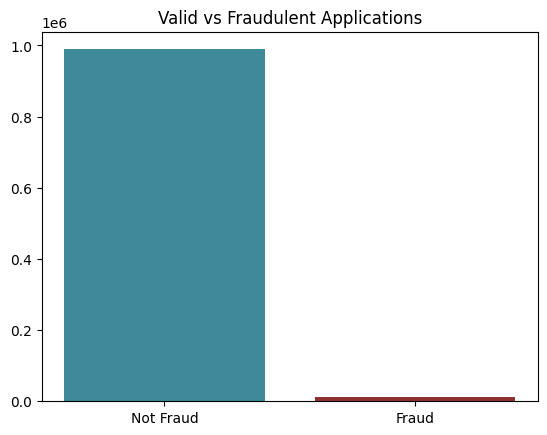

In [76]:
blue = (63/255, 137/255, 155/255, 255/255)
red = (140/255 ,49/255, 48/255 , 255/255)
plt.bar(["Not Fraud", "Fraud"], [n_not_fraud, n_fraud], color = [blue, red])
plt.title("Valid vs Fraudulent Applications")
plt.show()

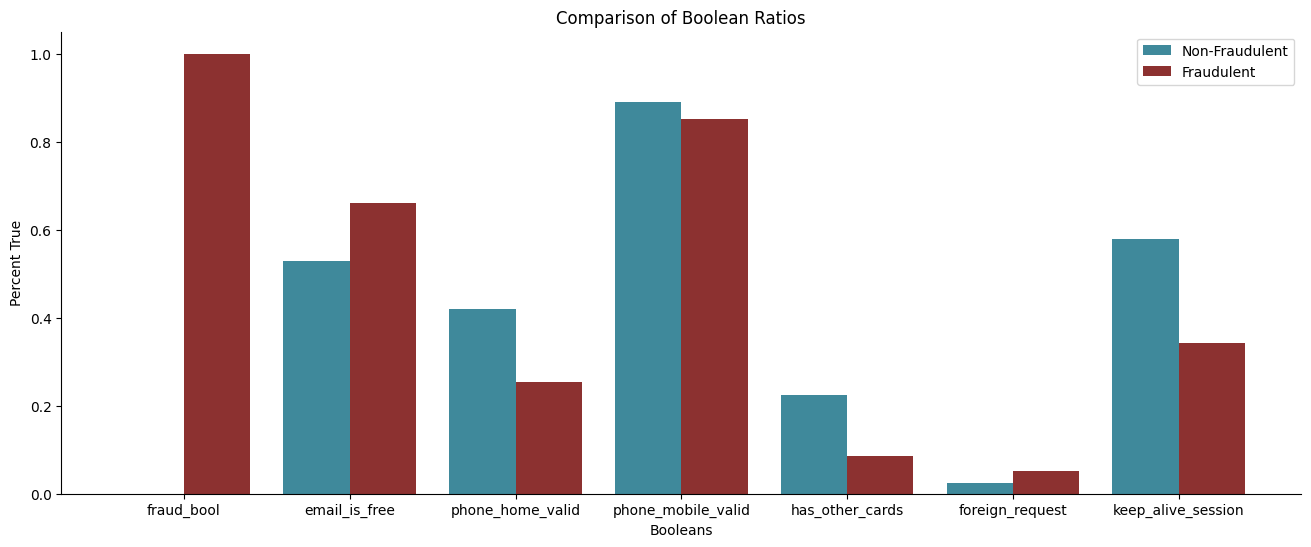

In [77]:
nf_ratios = list()
f_ratios = list()

for bool in bools:
    non_fraud_counts = df_master[df_master["fraud_bool"]==0][bool].value_counts()
    fraud_counts = df_master[df_master["fraud_bool"]==1][bool].value_counts()
    #print(non_fraud_counts)
    #print(fraud_counts)
    nf_ratio = (sum(non_fraud_counts) - non_fraud_counts[0]) / sum(non_fraud_counts)
    f_ratio = (fraud_counts[1]) / sum(fraud_counts)
    
    nf_ratios.append(nf_ratio)
    f_ratios.append(f_ratio)

X_axis = np.arange(len(bools))

#print(nf_ratios)
#print(f_ratios)

plt.figure(figsize=(16, 6))
plt.bar(X_axis - 0.2, nf_ratios, 0.4, label = 'Non-Fraudulent', color = blue)
plt.bar(X_axis + 0.2, f_ratios, 0.4, label = 'Fraudulent', color= red)

plt.xticks(X_axis, bools)
plt.title("Comparison of Boolean Ratios")
plt.xlabel("Booleans")
plt.ylabel("Percent True")
plt.legend()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

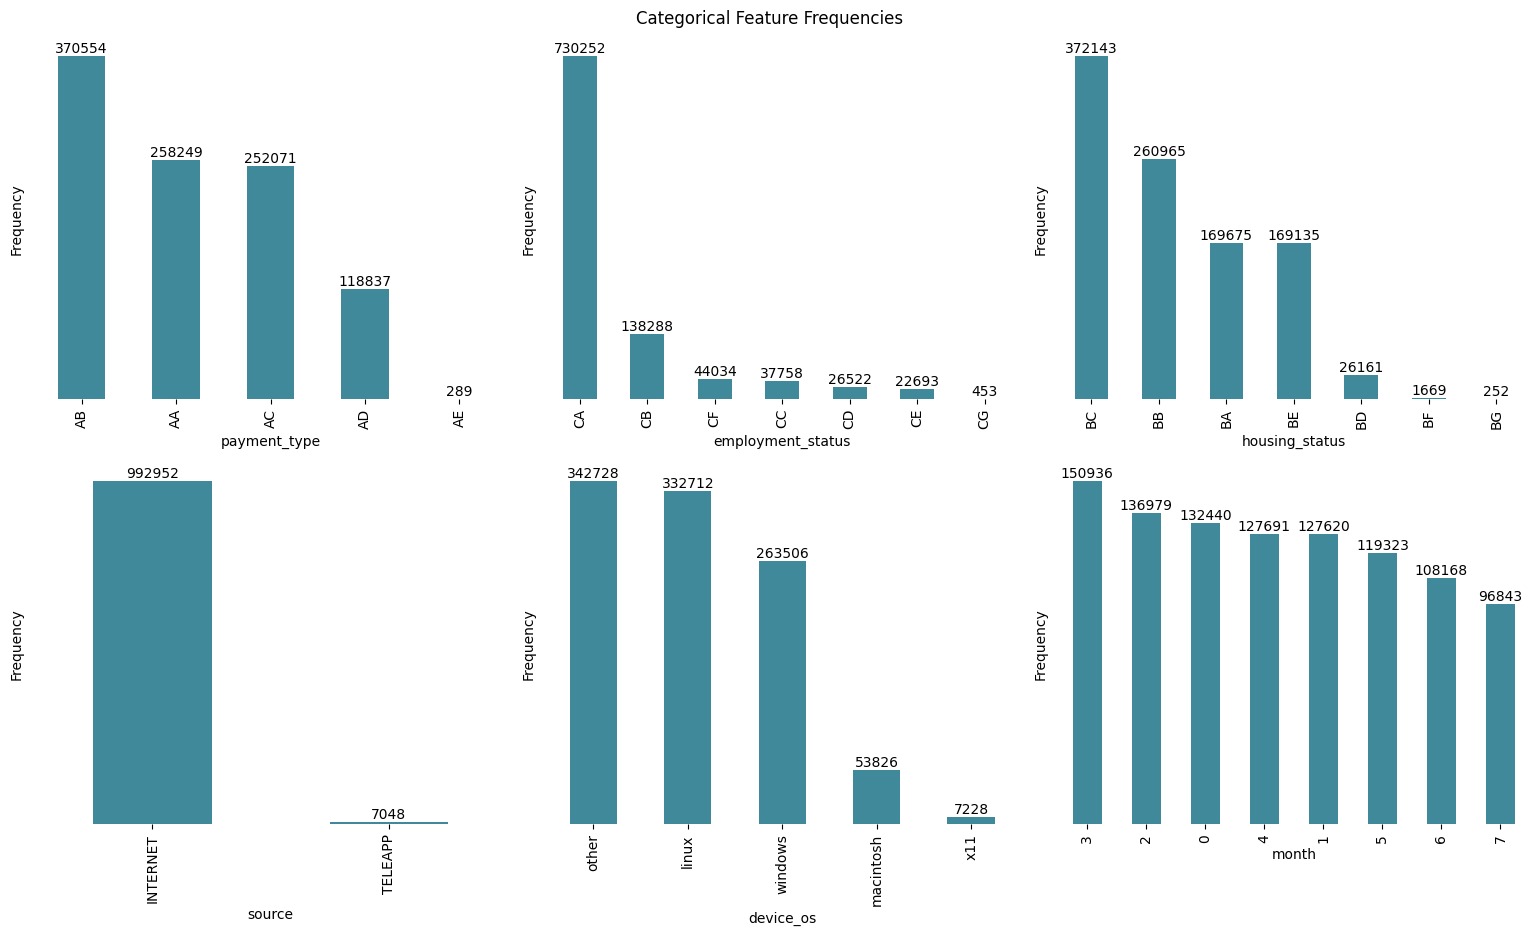

In [78]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15.5,9.5))

cats.append("month")

for i, cat in enumerate(cats):
    ax = axes[i // 3][i % 3]
    ax = df_master[cat].value_counts().plot(kind="bar", ax = ax, color = blue)
    ax.set_xlabel(cat)
    ax.set_ylabel("Frequency")
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticklabels(df_master[cat].value_counts().index)

    rects = ax.patches

    # Make some labels.
    labels = df_master[cat].value_counts()

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
fig.suptitle("Categorical Feature Frequencies")
#fig.delaxes(axes[-1,-1])
fig.tight_layout()


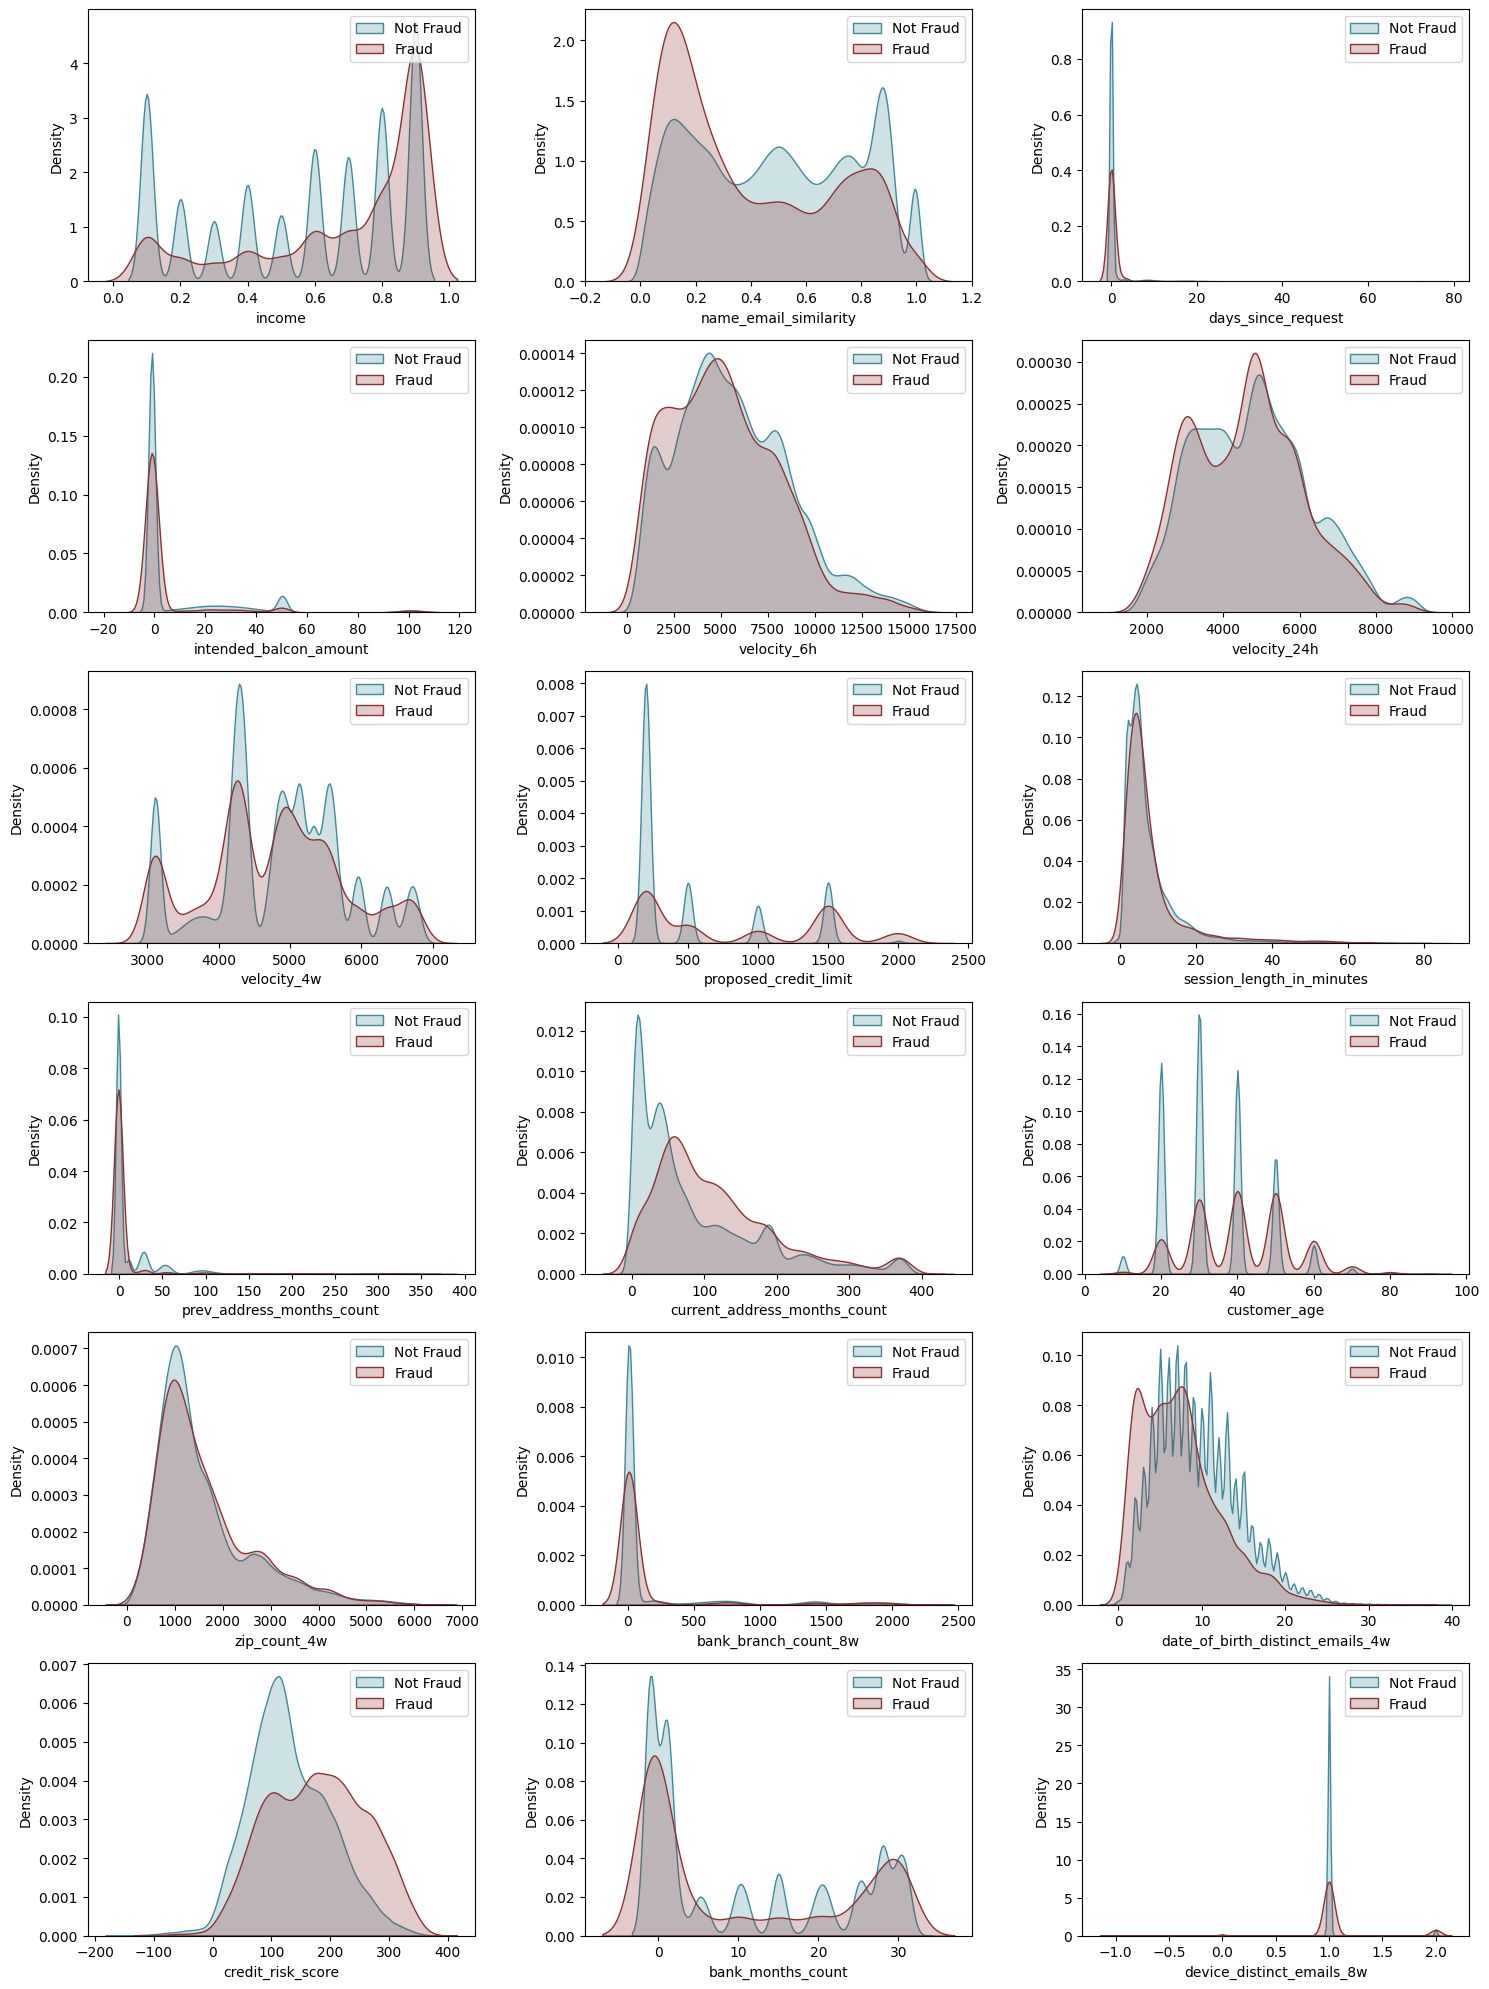

In [79]:

# Create a grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 20))

# Add a title to the figure
#fig.suptitle('Distribution of Numeric Features by Fraud Status')

# Loop through the numeric features and plot a kernel density plot for each feature
for i, feature in enumerate(nums + counts):
    if i >= 6 * 3: break #don't want month plotted
    ax = axes[i // 3][i % 3]
    sns.kdeplot(data=df_master[df_master['fraud_bool'] == 0][feature], fill=True, ax=ax, label='Not Fraud', color=blue)
    sns.kdeplot(data=df_master[df_master['fraud_bool'] == 1][feature], fill=True, ax=ax, label='Fraud', color=red)
    ax.set_xlabel(feature)
    ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

## Handle Missing Data

In [80]:
rand_state = 171827 # To make method comparison more fair
# Create training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(df_master.loc[:, [c for c in df_master.columns if c not in ["fraud_bool", "customer_age"]]], df_master["fraud_bool"], random_state=rand_state) # Separate test set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=rand_state) # Create training and validation sets from remaining data

# Make a copy with target column for grouping in charts 
df = X_train.copy()
df["fraud_bool"] = y_train.copy()

The data set represents missing values with "-1" for the following columns:
<br>- current_address_months_count
<br>- session_length_in_minutes
<br>- device_distinct_emails_8w

In [81]:
from scipy.stats import chi2_contingency

In [82]:
# Features where -1 represents missing value
missing_feats = [
    "current_address_months_count",
    "session_length_in_minutes",
    "device_distinct_emails_8w"
]

### Check for Missing Randomness

In [83]:
a = .01
for feat in missing_feats:
    # Get Count of missing values for fraud vs non fraud
    miss = df[df[feat]==-1].groupby("fraud_bool")[feat].count()
    no_miss = df[df[feat]!=-1].groupby("fraud_bool")[feat].count()
    # Check for missing randomness
    chi2, p, dof, ex = chi2_contingency([[miss[0], no_miss[0]],[miss[1],no_miss[1]]])
    # Print results
    if p < a:
        print(f"{feat} missing NOT AT RANDOM, p = {p}")
    else: print(f"{feat} missing AT RANDOM, p = {p}")
    print(f"""
    #           | Missing (True)  | Not Missing (False) | Ratio Miss/No Miss
    # No Fraud  | {miss[0]}\t\t| {no_miss[0]}\t\t| {miss[0]/no_miss[0]}
    # Fraud     | {miss[1]}\t\t| {no_miss[1]}\t\t| {miss[1]/no_miss[1]}
    """)

current_address_months_count missing NOT AT RANDOM, p = 0.003677998419756962

    #           | Missing (True)  | Not Missing (False) | Ratio Miss/No Miss
    # No Fraud  | 2393		| 553959		| 0.004319814282284429
    # Fraud     | 11		| 6137		| 0.0017924067133778718
    
session_length_in_minutes missing AT RANDOM, p = 0.14939489035482426

    #           | Missing (True)  | Not Missing (False) | Ratio Miss/No Miss
    # No Fraud  | 1144		| 555208		| 0.0020604890419446405
    # Fraud     | 7		| 6141		| 0.0011398794984530207
    
device_distinct_emails_8w missing AT RANDOM, p = 0.6407905171335595

    #           | Missing (True)  | Not Missing (False) | Ratio Miss/No Miss
    # No Fraud  | 199		| 556153		| 0.0003578152055279752
    # Fraud     | 1		| 6147		| 0.00016268098259313488
    


### Missing at Random

Because of the large size of our dataset and the small amount of instances with missing data for our 2 features we determined were missing at random, we can simply drop the instances that are missing these values. <br>Note: This is done in out "transform_df" func so we can easily do the same thing to future data.

### Missing Not At Random

**current address months count** is our only feature missing not at random. We will use the SKLearn Iterative Imputer to replace the missing values.

From SKLearn docs: "A more sophisticated approach is to use the IterativeImputer class, which models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y. This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. The results of the final imputation round are returned."

In summary: values are imputed by multiple regression models using the other features as inputs.

## Data Transformations

Categorical Data: One hot encoded
<br>Numeric Data:
<br>- If skewed: Log transformed
<br>- All Numeric Data: Min-Max Scaled

In [84]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, MinMaxScaler, StandardScaler
from sklearn.impute import IterativeImputer
import importlib
from sklearn import set_config

Note: All missingness and transformations handled in function below
<br> Here we also split data in to training, validation, and test sets.

In [85]:
# Create training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_master.loc[:, [c for c in df_master.columns if c not in ["fraud_bool", "customer_age"]]],
    df_master["fraud_bool"],
    random_state=rand_state) # Separate test set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=rand_state) # Create training and validation sets from remaining data

# Make a copy with target column for grouping in charts 
df = X_train.copy()
df["fraud_bool"] = y_train.copy()

# Define our cols by type
one_hot_cols = [
        "payment_type", "employment_status", "housing_status",
        "source", "device_os"
    ]
skewed_cols = [
    "days_since_request", "intended_balcon_amount", "proposed_credit_limit",
    "current_address_months_count", "prev_address_months_count",
    "zip_count_4w", "bank_branch_count_8w", "date_of_birth_distinct_emails_4w",
    "bank_months_count"
]
std_cols = [
    "session_length_in_minutes", "velocity_6h", "velocity_24h", "device_distinct_emails_8w", "credit_risk_score"
]
minmax_cols = [
    "income", "name_email_similarity", "velocity_4w", "month"
]

# Fit OHE on training data
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
ohe.fit(np.array(X_train[one_hot_cols]))

# Fit imputer on training data
imputer  = IterativeImputer(random_state=42)
num_cols = skewed_cols + std_cols + minmax_cols
X_train.loc[X_train["current_address_months_count"]==-1,"current_address_months_count"] = np.nan #Only column we want imputed
imputer.fit(X_train.loc[:,num_cols])

# Fit scalers to training data
log_cols = ["session_length_in_minutes"]
X_train[log_cols] = np.log(X_train[log_cols] + 2)
mm_scaler = MinMaxScaler().fit(X_train[minmax_cols + std_cols + skewed_cols])
pw_tranformer = PowerTransformer().fit(X_train[skewed_cols])
#std_scaler = StandardScaler().fit(df[std_cols]) # IF UNCOMMENT THE UN COMMENT IN FUNCS ALSO

#Transform all data sets
importlib.reload(funcs)
df_list = [X_train, X_valid, X_test]
target_list = [y_train, y_valid, y_test]
df_list_transformed = list()
for i, df in enumerate(df_list):
    y = target_list[i]
    df["target"] = y
    df_transformed = funcs.transform_df2(
        df,
        imputer_fitted = imputer,
        ohe = ohe,
        #std_scaler = std_scaler,
        std_scaler = None,
        power_transformer = pw_tranformer,
        min_max_scaler = mm_scaler,
        do_log_transform = (i != 0) # X_train done before fitting scalers
        )
    df_list_transformed.append(df_transformed)
df_list_transformed[0].describe().T


c:\Users\Dylan\Documents\OU\DSA5900\Steimel_OUDSA5900\funcs.py:130: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
c:\Users\Dylan\Documents\OU\DSA5900\Steimel_OUDSA5900\funcs.py:130: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
c:\Users\Dylan\Documents\OU\DSA5900\Steimel_OUDSA5900\funcs.py:130: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)

,count,mean,std,min,25%,50%,75%,max
income,562300.0,0.578657,0.362794,0.000000,0.250000,0.625000,0.875000,1.0
name_email_similarity,562300.0,0.493639,0.289194,0.000000,0.224949,0.492416,0.755369,1.0
prev_address_months_count,562300.0,0.046235,0.114709,0.000000,0.000000,0.000000,0.033854,1.0
current_address_months_count,562300.0,0.204416,0.207792,-0.252121,0.047059,0.124706,0.305882,1.0
days_since_request,562300.0,0.013039,0.068367,0.000000,0.000091,0.000193,0.000335,1.0
intended_balcon_amount,562300.0,0.188426,0.157696,0.000000,0.111676,0.114412,0.161281,1.0
zip_count_4w,562300.0,0.234565,0.150058,0.000000,0.133154,0.188386,0.290043,1.0
velocity_6h,562300.0,0.347295,0.179253,0.000000,0.214590,0.326517,0.467454,1.0
velocity_24h,562300.0,0.421568,0.180871,0.000000,0.277635,0.419028,0.541807,1.0
velocity_4w,562300.0,0.484798,0.223648,0.000000,0.341795,0.498696,0.638616,1.0


KeyError: 'customer_age'

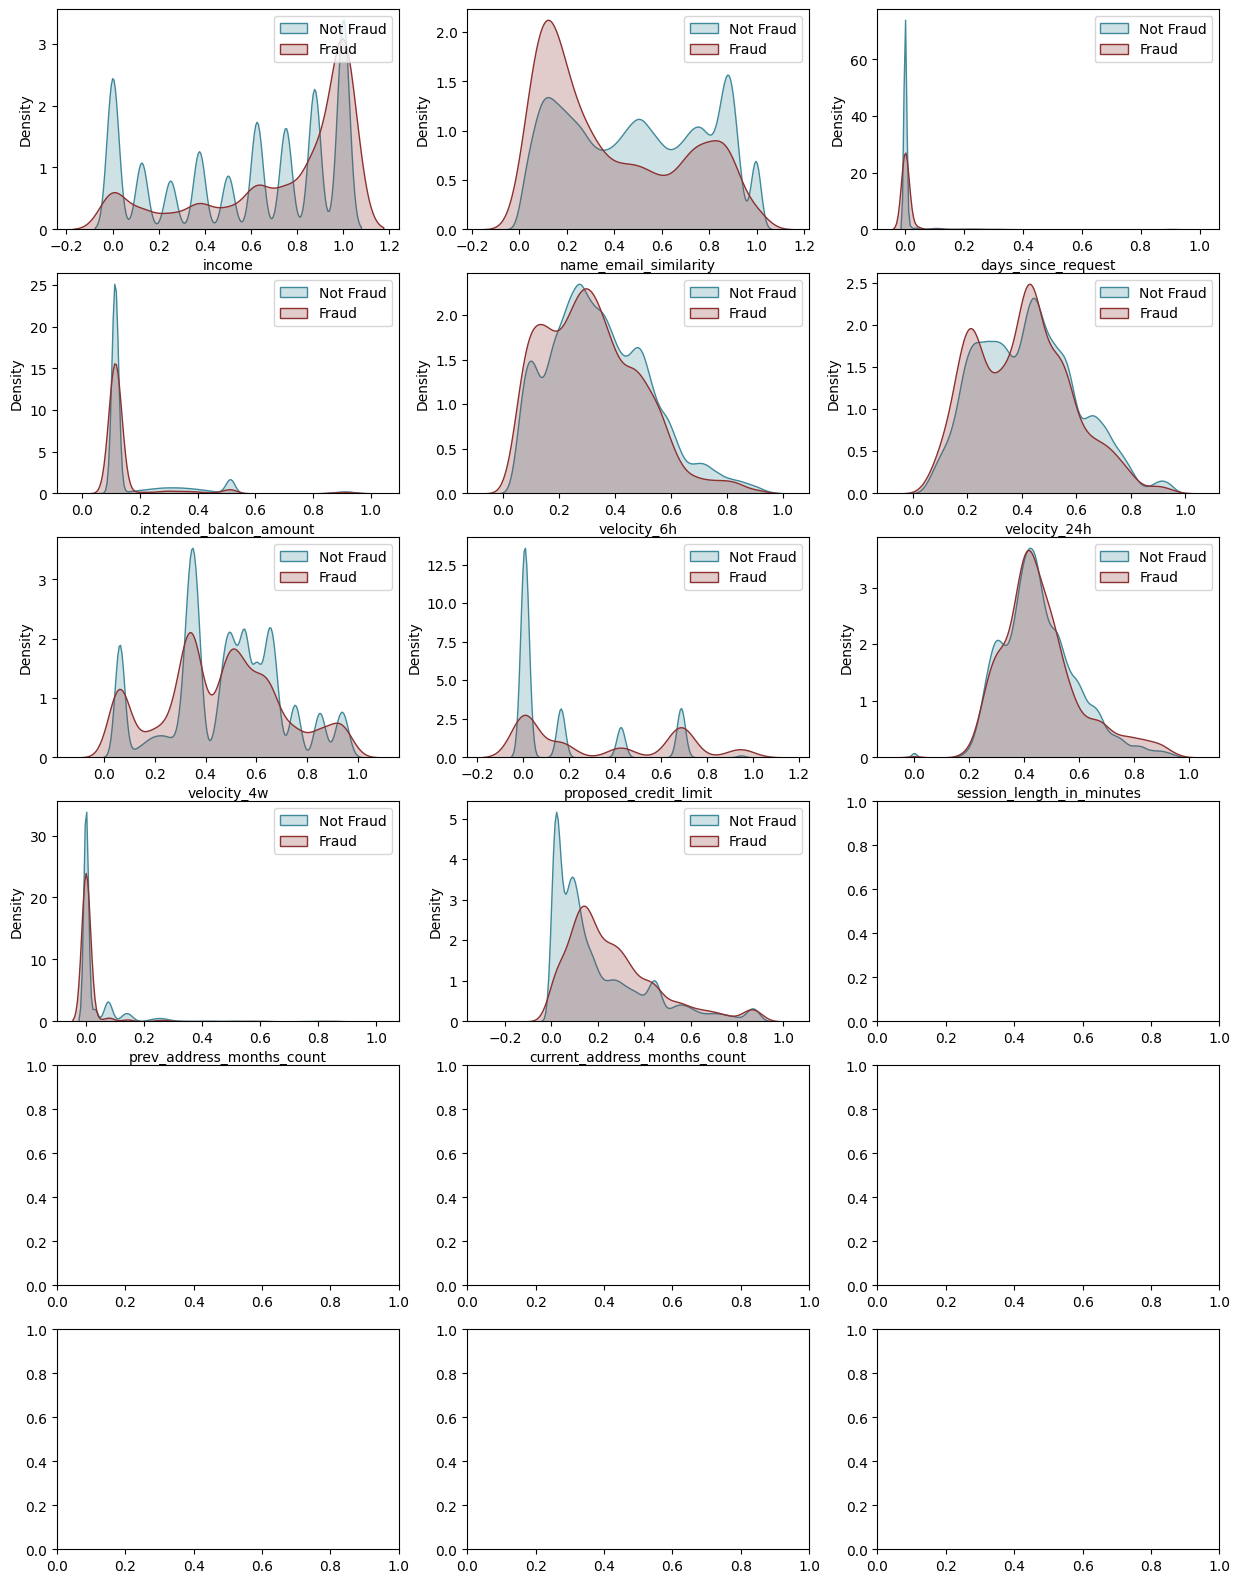

In [86]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 20))

# Add a title to the figure
#fig.suptitle('Distribution of Numeric Features by Fraud Status')

# Loop through the numeric features and plot a kernel density plot for each feature
for i, feature in enumerate(nums + counts):
    if i >= 6 * 3: break #don't want month plotted
    ax = axes[i // 3][i % 3]
    sns.kdeplot(data=df_list_transformed[0][df_list_transformed[0]['target'] == 0][feature], fill=True, ax=ax, label='Not Fraud', color=blue)
    sns.kdeplot(data=df_list_transformed[0][df_list_transformed[0]['target'] == 1][feature], fill=True, ax=ax, label='Fraud', color=red)
    ax.set_xlabel(feature)
    ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [87]:
df_transformed

,income,name_email_similarity,prev_address_months_count,current_address_months_count,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,...,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_TELEAPP,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
100847,0.000,0.139808,0.078125,0.007059,0.011792,0.195575,0.215256,0.108130,0.485169,0.558147,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
474455,0.750,0.730035,0.031250,0.016471,0.000032,0.118204,0.201672,0.623185,0.491013,0.599207,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8137,0.125,0.068251,0.000000,0.098824,0.000124,0.112821,0.167338,0.533898,0.197034,0.041866,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
540363,1.000,0.282922,0.000000,0.089412,0.000102,0.113979,0.195104,0.054667,0.201848,0.343198,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
589908,0.750,0.153618,0.093750,0.032941,0.000339,0.880307,0.150769,0.196341,0.179841,0.334731,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251348,0.125,0.816795,0.072917,0.030588,0.123743,0.509114,0.183460,0.547260,0.680295,0.577147,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
783037,0.625,0.184766,0.000000,0.131765,0.000039,0.109895,0.405434,0.082802,0.335682,0.375657,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
929830,1.000,0.028293,0.000000,0.094118,0.000050,0.861553,0.265562,0.247582,0.518210,0.510745,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
638031,0.625,0.993483,0.000000,0.025882,0.000420,0.112555,0.151515,0.558646,0.702997,0.733296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
# Store transformed data as variables
X_train_transformed, X_valid_transformed, X_test_transformed = [df.loc[:, df.columns != "target"] for df in df_list_transformed]
y_train_transformed, y_valid_transformed, y_test_transformed = [df["target"] for df in df_list_transformed]

## Modeling

In [89]:
import scipy.stats.distributions as dist
import scipy.stats as stats
import itertools
from sklearn.metrics import log_loss
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [90]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

DEFAULT_HIDDEN_LAYERS = [
  Dense(13, activation='relu')
]

def make_model(
  metrics=METRICS,
  output_bias=None,
  X_train = X_train_transformed.values,
  hlayer1 = None,
  hidden_layers = DEFAULT_HIDDEN_LAYERS,
  outlayer = None,
  outsize = 1,
  opt = "adam",
  loss = keras.losses.BinaryCrossentropy()
  ):
  """Make a tensorflow model with given inputs"""
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = Sequential()
  # Add first hidden layer
  if hlayer1 is None:
    model.add(Dense(np.rint(X_train.shape[-1] * (2/ 3)), input_dim=X_train.shape[-1], activation='relu'))
  else: model.add(hlayer1)
  # Add middle hidden layers
  for layer in hidden_layers:
    print("adding layer:", layer)
    model.add(layer)
  # Add output layer
  if outlayer is None:
    model.add(
        Dense(
          outsize, 
          activation='sigmoid',
          bias_initializer=output_bias
        )
    )
  else: model.add(outlayer)
  # Compile model
  model.compile(
      optimizer=opt,
      loss=loss,
      metrics=metrics)

  return model

### Imbalanced Data Technique Tests

In [91]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [92]:
model = make_model()
model.summary()

adding layer: <keras.layers.core.dense.Dense object at 0x000002081F4B4490>
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 30)                1380      
                                                                 
 dense_17 (Dense)            (None, 13)                403       
                                                                 
 dense_19 (Dense)            (None, 1)                 14        
                                                                 
Total params: 1,797
Trainable params: 1,797
Non-trainable params: 0
_________________________________________________________________


In [93]:
#Test Run
model.predict(X_train_transformed.values[:10])

1/1 [==============================] - 0s 101ms/step


array([[0.8277242 ],
       [0.8594285 ],
       [0.8079632 ],
       [0.862869  ],
       [0.80826163],
       [0.8502992 ],
       [0.83670765],
       [0.8060509 ],
       [0.82702965],
       [0.7649125 ]], dtype=float32)

In [94]:
results = model.evaluate(
    X_train_transformed.values,
    y_train_transformed.values,
    batch_size=BATCH_SIZE,
    verbose=0
)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.7582


#### Output Bias

In [95]:
pos = sum(y_train_transformed)
neg = len(y_train_transformed) - pos
total = pos + neg
initial_bias = np.log([pos / neg]) # Output bias

In [96]:
# Now make model with output bias
model = make_model(output_bias = initial_bias)
model.predict(X_train_transformed.values[:10])

adding layer: <keras.layers.core.dense.Dense object at 0x000002081F4B4490>
1/1 [==============================] - 0s 43ms/step


array([[0.00617272],
       [0.00710791],
       [0.00909856],
       [0.00698394],
       [0.00923835],
       [0.01309409],
       [0.00832707],
       [0.00771211],
       [0.00838856],
       [0.01070371]], dtype=float32)

In [97]:
results = model.evaluate(
    X_train_transformed.values,
    y_train_transformed.values,
    batch_size=BATCH_SIZE,
    verbose=0
)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0603


In [98]:
import tempfile

In [99]:
# Save weights for fair comparison
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

#### Confirm bias helps

In [100]:
val_data = (
    X_valid_transformed.values,
    y_valid_transformed.values
)

In [101]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train_transformed,
    y_train_transformed,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=val_data, 
    verbose=0)

adding layer: <keras.layers.core.dense.Dense object at 0x000002081F4B4490>


In [102]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train_transformed,
    y_train_transformed,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=val_data, 
    verbose=0)

adding layer: <keras.layers.core.dense.Dense object at 0x000002081F4B4490>


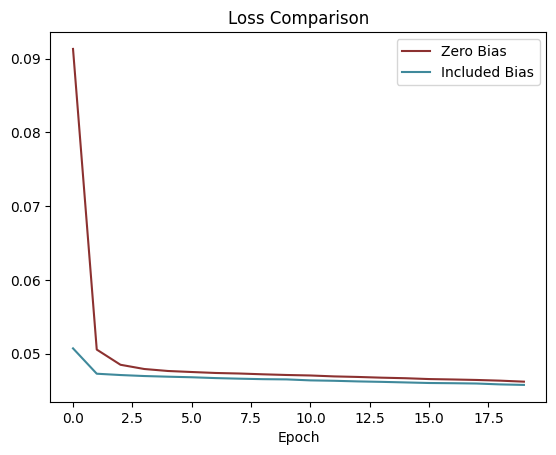

In [103]:
plt.plot(range(len(zero_bias_history.history["loss"])),zero_bias_history.history["loss"], label = "Zero Bias", color = red)
plt.plot(range(len(careful_bias_history.history["loss"])),careful_bias_history.history["loss"], label = "Included Bias", color = blue)
plt.title("Loss Comparison")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [104]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train_transformed,
    y_train_transformed,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=val_data)

adding layer: <keras.layers.core.dense.Dense object at 0x000002081F4B4490>
Epoch 1/100
275/275 [==============================] - 2s 4ms/step - loss: 0.0511 - tp: 14.0000 - fp: 7.0000 - tn: 741131.0000 - fn: 8266.0000 - accuracy: 0.9890 - precision: 0.6667 - recall: 0.0017 - auc: 0.8290 - prc: 0.0946 - val_loss: 0.0496 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 184985.0000 - val_fn: 2133.0000 - val_accuracy: 0.9886 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8519 - val_prc: 0.1138
Epoch 2/100
275/275 [==============================] - 1s 2ms/step - loss: 0.0473 - tp: 2.0000 - fp: 3.0000 - tn: 556150.0000 - fn: 6145.0000 - accuracy: 0.9891 - precision: 0.4000 - recall: 3.2536e-04 - auc: 0.8556 - prc: 0.1236 - val_loss: 0.0494 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 184985.0000 - val_fn: 2133.0000 - val_accuracy: 0.9886 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8501 - val_prc: 0.1185
Epoch 3/100
275/275 [=================

In [105]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=blue, label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=red, linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

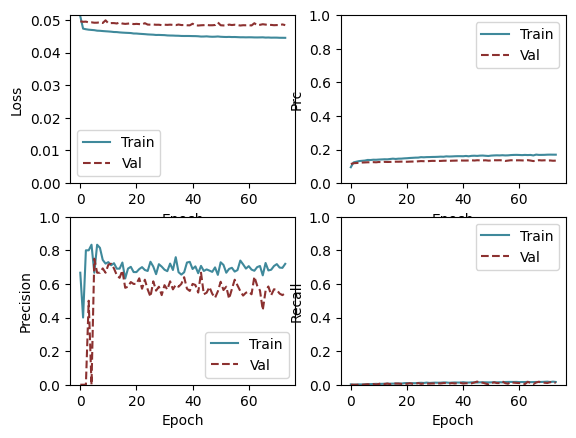

In [106]:
plot_metrics(baseline_history)

In [107]:
train_predictions_baseline = model.predict(X_train_transformed, batch_size=BATCH_SIZE)
valid_predictions_baseline = model.predict(X_valid_transformed, batch_size=BATCH_SIZE)

92/92 [==============================] - 0s 899us/step


In [108]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.0483633391559124
tp :  36.0
fp :  25.0
tn :  184960.0
fn :  2097.0
accuracy :  0.9886595606803894
precision :  0.5901639461517334
recall :  0.016877636313438416
auc :  0.8584531545639038
prc :  0.1365787535905838

Legitimate Transactions Detected (True Negatives):  184960
Legitimate Transactions Incorrectly Detected (False Positives):  25
Fraudulent Transactions Missed (False Negatives):  2097
Fraudulent Transactions Detected (True Positives):  36
Total Fraudulent Transactions:  2133


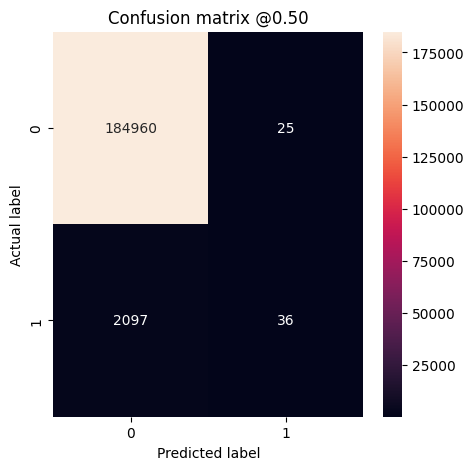

In [109]:
baseline_results = model.evaluate(
  X_valid_transformed,
  y_valid_transformed,
  batch_size=BATCH_SIZE,
  verbose=0
)

for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_valid_transformed, valid_predictions_baseline)

In [110]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,40])
  plt.ylim([60,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

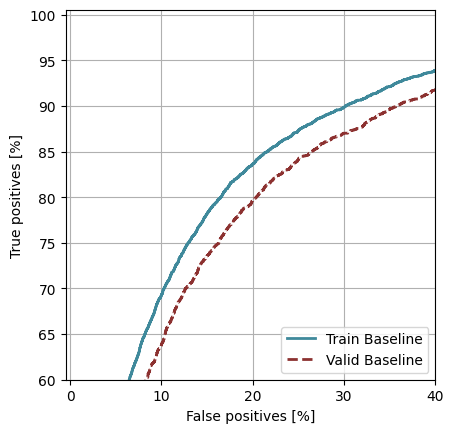

In [111]:
plot_roc("Train Baseline", y_train_transformed, train_predictions_baseline, color=blue)
plot_roc("Valid Baseline", y_valid_transformed, valid_predictions_baseline, color=red, linestyle='--')
plt.legend(loc='lower right')

In [112]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

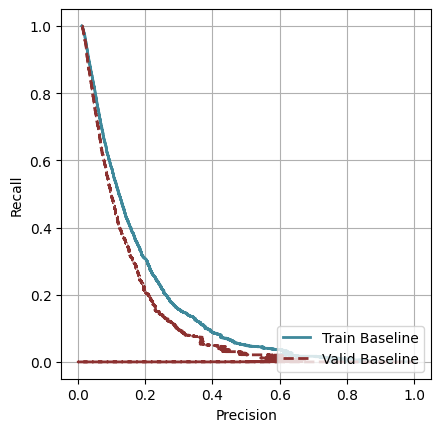

In [113]:
plot_prc("Train Baseline", y_train_transformed, train_predictions_baseline, color=blue)
plot_prc("Valid Baseline", y_valid_transformed, valid_predictions_baseline, color=red, linestyle='--')
plt.legend(loc='lower right')

#### Class Weights

In [114]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 45.74


In [115]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train_transformed,
    y_train_transformed,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=val_data,
    # The class weights go here
    class_weight=class_weight)

adding layer: <keras.layers.core.dense.Dense object at 0x000002081F4B4490>
Epoch 1/100
275/275 [==============================] - 2s 4ms/step - loss: 0.9044 - tp: 2940.0000 - fp: 112805.0000 - tn: 628333.0000 - fn: 5340.0000 - accuracy: 0.8424 - precision: 0.0254 - recall: 0.3551 - auc: 0.6335 - prc: 0.0383 - val_loss: 0.4932 - val_tp: 1654.0000 - val_fp: 43059.0000 - val_tn: 141926.0000 - val_fn: 479.0000 - val_accuracy: 0.7673 - val_precision: 0.0370 - val_recall: 0.7754 - val_auc: 0.8457 - val_prc: 0.0956
Epoch 2/100
275/275 [==============================] - 1s 2ms/step - loss: 0.4648 - tp: 4731.0000 - fp: 114279.0000 - tn: 441874.0000 - fn: 1416.0000 - accuracy: 0.7942 - precision: 0.0398 - recall: 0.7696 - auc: 0.8617 - prc: 0.1128 - val_loss: 0.4218 - val_tp: 1618.0000 - val_fp: 34199.0000 - val_tn: 150786.0000 - val_fn: 515.0000 - val_accuracy: 0.8145 - val_precision: 0.0452 - val_recall: 0.7586 - val_auc: 0.8647 - val_prc: 0.1126
Epoch 3/100
275/275 [==========================

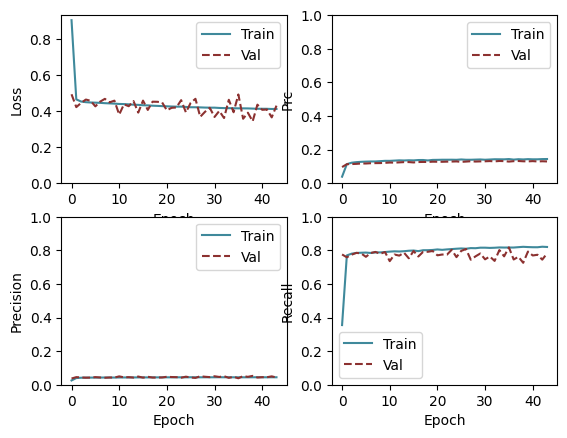

In [116]:
plot_metrics(weighted_history)

In [117]:
train_predictions_weighted = weighted_model.predict(X_train_transformed, batch_size=BATCH_SIZE)
valid_predictions_weighted = weighted_model.predict(X_valid_transformed, batch_size=BATCH_SIZE)

92/92 [==============================] - 0s 997us/step


loss :  0.46253764629364014
tp :  1709.0
fp :  39999.0
tn :  144986.0
fn :  424.0
accuracy :  0.7839705348014832
precision :  0.04097535088658333
recall :  0.8012189269065857
auc :  0.8753014206886292
prc :  0.13172173500061035

Legitimate Transactions Detected (True Negatives):  144986
Legitimate Transactions Incorrectly Detected (False Positives):  39999
Fraudulent Transactions Missed (False Negatives):  424
Fraudulent Transactions Detected (True Positives):  1709
Total Fraudulent Transactions:  2133


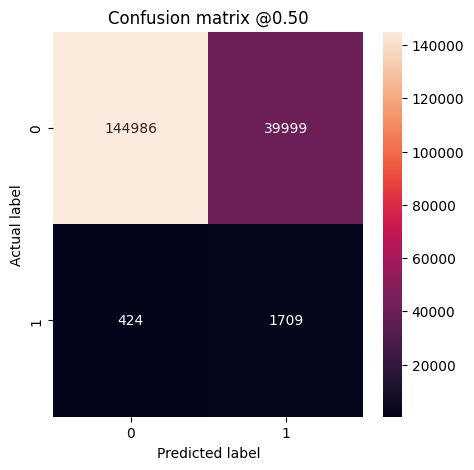

In [118]:
weighted_results = weighted_model.evaluate(X_valid_transformed, y_valid_transformed,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_valid_transformed, valid_predictions_weighted)

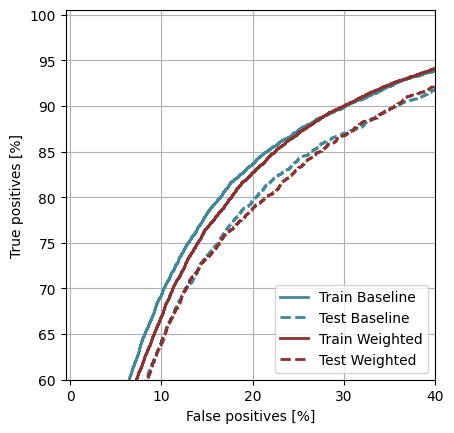

In [119]:
plot_roc("Train Baseline", y_train_transformed, train_predictions_baseline, color=blue)
plot_roc("Test Baseline", y_valid_transformed, valid_predictions_baseline, color=blue, linestyle='--')

plot_roc("Train Weighted", y_train_transformed, train_predictions_weighted, color=red)
plot_roc("Test Weighted", y_valid_transformed, valid_predictions_weighted, color=red, linestyle='--')

plt.legend(loc='lower right')

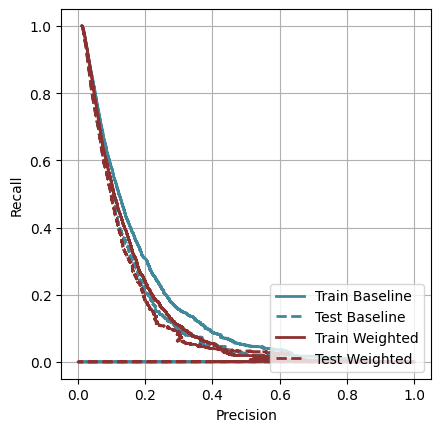

In [120]:
plot_prc("Train Baseline", y_train_transformed, train_predictions_baseline, color=blue)
plot_prc("Test Baseline", y_valid_transformed, valid_predictions_baseline, color=blue, linestyle='--')

plot_prc("Train Weighted", y_train_transformed, train_predictions_weighted, color=red)
plot_prc("Test Weighted", y_valid_transformed, valid_predictions_weighted, color=red, linestyle='--')

plt.legend(loc='lower right')

#### Over Sampling

In [121]:
# Over sample
bool_train_labels = y_train_transformed != 0
pos_features = X_train_transformed[bool_train_labels].values
neg_features = X_train_transformed[~bool_train_labels].values

pos_labels = y_train_transformed[bool_train_labels].values
neg_labels = y_train_transformed[~bool_train_labels].values

In [122]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(556153, 45)

In [123]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(1112306, 45)

In [124]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [125]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [1.00000000e+00 7.78598454e-01 0.00000000e+00 1.22352941e-01
 4.54414980e-05 1.14209810e-01 4.94849978e-01 6.16170016e-01
 7.42070926e-01 5.98506808e-01 0.00000000e+00 1.53846154e-01
 4.72271914e-01 1.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 5.23560209e-03 0.00000000e+00
 4.36081385e-01 0.00000000e+00 6.66666667e-01 2.85714286e-01
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]

Label:  1


In [126]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [127]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

544.0

In [128]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_data)

adding layer: <keras.layers.core.dense.Dense object at 0x000002081F4B4490>
Epoch 1/100
544/544 [==============================] - 13s 22ms/step - loss: 0.4663 - tp: 429166.0000 - fp: 150491.0000 - tn: 591048.0000 - fn: 130525.0000 - accuracy: 0.7840 - precision: 0.7404 - recall: 0.7668 - auc: 0.8607 - prc: 0.8157 - val_loss: 0.4441 - val_tp: 1651.0000 - val_fp: 36520.0000 - val_tn: 148465.0000 - val_fn: 482.0000 - val_accuracy: 0.8023 - val_precision: 0.0433 - val_recall: 0.7740 - val_auc: 0.8692 - val_prc: 0.1179
Epoch 2/100
544/544 [==============================] - 11s 21ms/step - loss: 0.4331 - tp: 445057.0000 - fp: 108556.0000 - tn: 448827.0000 - fn: 111672.0000 - accuracy: 0.8023 - precision: 0.8039 - recall: 0.7994 - auc: 0.8815 - prc: 0.8769 - val_loss: 0.4370 - val_tp: 1651.0000 - val_fp: 36541.0000 - val_tn: 148444.0000 - val_fn: 482.0000 - val_accuracy: 0.8021 - val_precision: 0.0432 - val_recall: 0.7740 - val_auc: 0.8709 - val_prc: 0.1237
Epoch 3/100
544/544 [==============

In [129]:
train_predictions_resampled = resampled_model.predict(X_train_transformed, batch_size=BATCH_SIZE)
valid_predictions_resampled = resampled_model.predict(X_valid_transformed, batch_size=BATCH_SIZE)

92/92 [==============================] - 0s 866us/step


loss :  0.4153285026550293
tp :  1628.0
fp :  34781.0
tn :  150204.0
fn :  505.0
accuracy :  0.8114237785339355
precision :  0.044714219868183136
recall :  0.7632442712783813
auc :  0.8728146553039551
prc :  0.12740543484687805

Legitimate Transactions Detected (True Negatives):  150204
Legitimate Transactions Incorrectly Detected (False Positives):  34781
Fraudulent Transactions Missed (False Negatives):  505
Fraudulent Transactions Detected (True Positives):  1628
Total Fraudulent Transactions:  2133


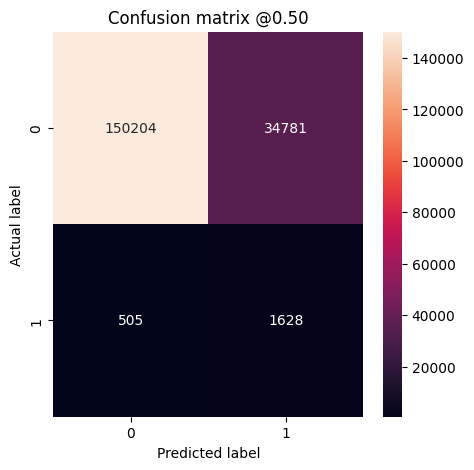

In [130]:
resampled_results = resampled_model.evaluate(X_valid_transformed, y_valid_transformed,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(y_valid_transformed, valid_predictions_resampled)

## Fairness

Beyond being a good classification model we want to make sure our model doesn't discriminate between groups. We will use the fairness metrics below to check the validity of the model with regard to fairness as iterate through hyper-parameters.

In [131]:
def get_disparity_df(model, X_val, prob_threshold=0.5):
    # Create pred df for easy comparisons
    y_pred = model.predict_proba(X_val)[:, 1]
    disparity_df = pd.DataFrame()
    disparity_df["true_label"] = y_valid_transformed
    disparity_df["pred_prob"] = y_pred
    # Get TP/TN/FP/FN
    disparity_df["pred_label"] = disparity_df["pred_prob"] > prob_threshold
    disparity_df["true_pos"] = (disparity_df['true_label'] == True) & (disparity_df['pred_label'] == True)
    disparity_df["true_neg"] = (disparity_df['true_label'] == False) & (disparity_df['pred_label'] == False)
    disparity_df["false_pos"] = (disparity_df['true_label'] == False) & (disparity_df['pred_label'] == True)
    disparity_df["false_neg"] = (disparity_df['true_label'] == True) & (disparity_df['pred_label'] == False)
    # Add in identifiers
    disparity_df["age"] = X_valid["customer_age"][disparity_df.index]
    disparity_df["income"] = X_valid["income"][disparity_df.index]
    disparity_df["employment_status"] = X_valid["employment_status"][disparity_df.index]
    return disparity_df

In [132]:
def get_parity_df(disparity_df, groups = ["age", "income", "employment_status"]):
    parity_df = pd.DataFrame(columns=["group", "group value","stat name", "value", "n samples", "pop value", "parity score", "has parity", "pval", "diff whole group"])
    i = 0
    for g in groups:
        for val in disparity_df[g].unique():
            sub = disparity_df[disparity_df[g] == val]
            pval, z, pop_fpr, group_fpr = get_fpr_fairness(disparity_df, sub)
            parity_df.loc[i] = [g,val,"fpr", group_fpr, len(sub), pop_fpr, z, pval > .01, pval, group_fpr - pop_fpr]
            i += 1   
    return parity_df

In [133]:
def get_disparity_df_tf(model, prob_threshold = 0.5, do_print=True):
    # Create pred df for easy comparisons
    y_pred = model(X_valid_transformed.values)
    disparity_df = pd.DataFrame()
    disparity_df["true_label"] = y_valid_transformed
    disparity_df["pred_prob"] = y_pred
    # Get TP/TN/FP/FN
    disparity_df["pred_label"] = disparity_df["pred_prob"] > prob_threshold
    disparity_df["true_pos"] = (disparity_df['true_label'] == True) & (disparity_df['pred_label'] == True)
    disparity_df["true_neg"] = (disparity_df['true_label'] == False) & (disparity_df['pred_label'] == False)
    disparity_df["false_pos"] = (disparity_df['true_label'] == False) & (disparity_df['pred_label'] == True)
    disparity_df["false_neg"] = (disparity_df['true_label'] == True) & (disparity_df['pred_label'] == False)
    # Add in identifiers
    disparity_df["age"] = df_master["customer_age"][disparity_df.index]
    disparity_df["income"] = df_master["income"][disparity_df.index]
    disparity_df["employment_status"] = df_master["employment_status"][disparity_df.index]
    if do_print: print(disparity_df)
    return disparity_df

#get_parity_df(get_disparity_df_tf(model_clf, do_print=False), groups=["age"])

In [134]:
def get_fpr_fairness(pop: pd.DataFrame, group: pd.DataFrame):
    np.seterr(all='ignore')
    # FPR = FP / FP + TN
    n1 = sum(pop["false_pos"]) + sum(pop["true_neg"])
    n2 = sum(group["false_pos"]) + sum(group["true_neg"]) 
    p1 = sum(pop["false_pos"]) / n1 # FP proportion for sample 1
    p2 = sum(group["false_pos"]) / n2 # FP proportion for sample 2
    p = (   # Proportion for combined samples
            (sum(pop["false_pos"]) + sum(group["false_pos"]))
            /(n1 + n2)
        )
    Z = (
        ((p1 - p2) - 0)
        / np.sqrt(p * (1-p) * ((1/n1)+(1/n2)))
    )
    pval = 2*dist.norm.cdf(-np.abs(Z))
    return pval, Z, p1, p2 #pval of difference, population fpr, group fpr

In [135]:
def get_fpr_fairness_1(fp_pop, tn_pop, fp_sub, tn_sub):
    # FPR = FP / FP + TN
    n1 = fp_pop + tn_pop
    n2 = fp_sub + tn_sub 
    p1 = fp_pop / n1 # FP proportion for sample 1
    p2 = fp_sub / n2 # FP proportion for sample 2
    p = (   # Proportion for combined samples
            (fp_pop + fp_sub)
            /(n1 + n2)
        )
    Z = (
        ((p1 - p2) - 0)
        / np.sqrt(p * (1-p) * ((1/n1)+(1/n2)))
    )
    pval = 2*dist.norm.cdf(-np.abs(Z))
    return pval, Z, p1, p2 #pval of difference, population fpr, group fpr

In [136]:
def get_disparity_dict(disparity_df, ok_fpr_diff = .05):
    fairness_cats = ["age", "income", "employment_status"]

    disparity_dict = dict()
    for cat in fairness_cats:
        cat_metrics = list()
        for val in disparity_df[cat].unique():
            sub = disparity_df[disparity_df[cat]==val]
            n_instances = len(sub.index)
            sub_tpr = sum(sub["true_pos"]) / n_instances
            sub_fpr = sum(sub["false_pos"]) / n_instances
            cat_metrics.append([val, n_instances, sub_tpr, sub_fpr, sub])
        disparity_dict[cat] = cat_metrics

    for cat in fairness_cats:
        max_fpr = -1
        max_val = None
        max_n = None
        min_fpr = 1
        min_val = None
        min_n = None
        for i in range(len(disparity_dict[cat])):
            cat_val = disparity_dict[cat][i][0]
            cat_n = disparity_dict[cat][i][1]
            if cat_n < 1000: continue
            cat_tpr = disparity_dict[cat][i][2]
            cat_fpr = disparity_dict[cat][i][3]
            if cat_fpr < min_fpr:
                min_fpr = cat_fpr
                min_val = cat_val
                min_n = cat_n
            if cat_fpr > max_fpr:
                max_fpr = cat_fpr
                max_val = cat_val
                max_n = cat_n
        if max_fpr - min_fpr <= ok_fpr_diff:
            print(f"""{cat} category is fair!
            Max fpr: {max_fpr}
            Max value: {max_val}
            Max n: {max_n}
            Min fpr: {min_fpr}
            Min value: {min_val}
            Min_n: {min_n}
            Difference: {max_fpr - min_fpr}""")
        else:
            print(f"""{cat} category is NOT fair!
            Max fpr: {max_fpr}
            Max value: {max_val}
            Max n: {max_n}
            Min fpr: {min_fpr}
            Min value: {min_val}
            Min n: {min_n}
            Difference: {max_fpr - min_fpr}""")
        print("\n\n")

        return disparity_dict

In [137]:
def plot_fpr_by_cat(disparity_dict):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    # Loop through the numeric features and plot a kernel density plot for each feature
    for i, cat in enumerate(disparity_dict):
        ax = axes[i]
        ax.bar([x[0] for x in disparity_dict[cat]], 
                [x[3] for x in disparity_dict[cat]])
        ax.set_xlabel(cat)
        ax.set_ylabel("fpr")
    plt.show()

## Adversarial Debiasing

In this section we build and tune our models, iterating through hyper-parameters for the methods described above. As well as for debiasing.

In [138]:
import scipy.stats.distributions as dist
import scipy.stats as stats
import itertools
from sklearn.metrics import log_loss
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
from fairlearn.metrics import equalized_odds_ratio, equalized_odds_difference, demographic_parity_ratio

### Build Model

In [139]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [140]:
# COPIED for less scrolling while debugging
def make_model(
  name,
  metrics=METRICS,
  output_bias=None,
  X_train = X_train_transformed.values,
  hlayer1 = None,
  hidden_layers = [Dense(13, activation='relu')],
  outlayer = None,
  outsize = 1,
  opt = "adam",
  loss = keras.losses.BinaryCrossentropy()
  ):
  """Make a tensorflow model with given inputs"""
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = Sequential(name=name)
  # Add first hidden layer
  if hlayer1 is None:
    model.add(Dense(np.rint(X_train.shape[-1] * (2/ 3)), input_dim=X_train.shape[-1], activation='relu'))
  else: model.add(hlayer1)
  # Add middle hidden layers
  for layer in hidden_layers:
    model.add(layer)
  # Add output layer
  if outlayer is None:
    model.add(
        Dense(
          outsize, 
          activation='sigmoid',
          bias_initializer=output_bias
        )
    )
  else: model.add(outlayer)
  # Compile model
  model.compile(
      optimizer=opt,
      loss=loss,
      metrics=metrics)

  return model

### Pretrain classifier

In [141]:
batch_size = 256
n_pretrain_epochs = 30
new_run = False # Set to true if pretrained models not saved

In [142]:
pos = sum(y_train_transformed)
neg = len(y_train_transformed) - pos
total = pos + neg
initial_bias = np.log([pos / neg]) # Output bias

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 4.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Initial output bias {initial_bias}")
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Initial output bias [-4.50507928]
Weight for class 0: 0.51
Weight for class 1: 22.87


In [143]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1
    )


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

def pretrain_classifier(
        model_name,
        class_weights,
        output_bias,
        hlayers,
        learning_rate,
        X_train,
        y_train,
        X_val,
        y_val,
        n_epochs = 200,
        callbacks = [reduce_lr, early_stopping]
        ):
    
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model = make_model(
                name=model_name,
                output_bias=output_bias,
                hidden_layers=hlayers,
                X_train=X_train,
                opt=opt
                )
        data_set = (X_val, y_val)
        

        history = model.fit(
                X_train,
                y_train,
                epochs=n_epochs,
                batch_size=256,
                class_weight=class_weights,
                validation_data = data_set,
                callbacks=callbacks
                )

        return model, history

In [144]:
def get_classifier_validity(
        history,
        best_epoch,
        min_recall = .4,
        min_precision = .035
    ):
    return ((history.history["val_recall"][best_epoch] >= min_recall) and (history.history["val_precision"][best_epoch] >= min_precision))
def get_classifier_validity_2(
        history,
        best_epoch,
        min_recall = .4,
        min_precision = .035
    ):
    return ((history["val_recall"][best_epoch] >= min_recall) and (history["val_precision"][best_epoch] >= min_precision))

In [145]:
if new_run:
    # Hyperparams to iterate over
    class_weights = [
        {0: weight_for_0, 1: weight_for_1},
        {0: weight_for_0, 1: weight_for_1 * .5},
        {0: weight_for_0, 1: weight_for_1 * .25},
        {0: weight_for_0, 1: weight_for_1 * .125},
        None
    ]
    output_bias = [
        initial_bias,
        None
    ]
    hlayers = [
        [Dense(13, activation='relu')],
        [Dense(13, activation='tanh')],
        [Dense(20, activation='relu'), Dense(10, activation='relu')],
    ]

    hidden_layers = [hlayers, hlayers1, hlayers2]
    learning_rate = [
        .1,
        .01,
        .001
    ]
    X_train = [
        X_train_transformed.values
    ]
    y_train = [y_train_transformed]
    names = ["Full", "No_Sensitive_Group", "PCA"]
    X_val = [
        X_valid_transformed.values
    ]
    y_val = [y_valid_transformed]

    all_params = [class_weights, output_bias, learning_rate, X_train, X_val, y_train, y_val]

    param_id = 0
    # Dict to store best parameters: lists represent [score, param_id, [params], model]
    best_params = {
        "Best Recall" : [-1, None, None, None],
        "Best Precision" : [-1, None, None, None],
        "Best AUC" : [-1, None, None, None],
        "Best Sum" : [-1, None, None, None]
    }
    combos = list(itertools.product(*all_params))
    print("TOTAL COMBINATIONS:", t := len(combos))
    for class_weights, output_bias, learning_rate, X_train, X_val, y_train, y_val in combos:
        current_params = [class_weights, output_bias, learning_rate, X_train, X_val, y_train, y_val]
        model, history = pretrain_classifier(
            "Full", # name
            class_weights,
            output_bias,
            [Dense(13, activation='relu')],
            learning_rate,
            X_train, # X train
            y_train,
            X_val, # X val
            y_val
        )

        if early_stopping.best_epoch == 0: best_epoch = len(history.history["val_precision"]) - 1
        else: best_epoch = early_stopping.best_epoch

        if get_classifier_validity(history, best_epoch):
            recall = history.history["val_recall"][best_epoch]
            prec = history.history["val_precision"][best_epoch]
            auc = history.history["val_auc"][best_epoch]
            s = recall + prec + auc

            if recall > best_params["Best Recall"][0]:
                best_params["Best Recall"] = [
                    recall,
                    param_id,
                    current_params,
                    model
                ]
            if prec > best_params["Best Precision"][0]:
                best_params["Best Precision"] = [
                    prec,
                    param_id,
                    current_params,
                    model
                ]
            if auc > best_params["Best AUC"][0]:
                best_params["Best AUC"] = [
                    auc,
                    param_id,
                    current_params,
                    model
                ]
            if s > best_params["Best Sum"][0]:
                best_params["Best Sum"] = [
                    s,
                    param_id,
                    current_params,
                    model
                ]
            
        param_id += 1
        print(f"ITER {param_id} / {t}")

In [146]:
model_clf, history = pretrain_classifier(
            "Full", # name
            {0: weight_for_0, 1: weight_for_1 * .5},
            initial_bias,
            [Dense(13, activation='relu')],
            .001,
            X_train_transformed.values, # X train
            y_train_transformed,
            X_valid_transformed.values, # X val
            y_valid_transformed
        )

Epoch 1/200


2197/2197 [==============================] - 5s 2ms/step - loss: 0.2287 - tp: 2540.0000 - fp: 24694.0000 - tn: 531459.0000 - fn: 3607.0000 - accuracy: 0.9497 - precision: 0.0933 - recall: 0.4132 - auc: 0.8387 - prc: 0.1033 - val_loss: 0.2146 - val_tp: 1158.0000 - val_fp: 13027.0000 - val_tn: 171958.0000 - val_fn: 975.0000 - val_accuracy: 0.9252 - val_precision: 0.0816 - val_recall: 0.5429 - val_auc: 0.8673 - val_prc: 0.1149 - lr: 0.0010
Epoch 2/200
2197/2197 [==============================] - 3s 1ms/step - loss: 0.2101 - tp: 3033.0000 - fp: 28830.0000 - tn: 527323.0000 - fn: 3114.0000 - accuracy: 0.9432 - precision: 0.0952 - recall: 0.4934 - auc: 0.8701 - prc: 0.1259 - val_loss: 0.1717 - val_tp: 955.0000 - val_fp: 8449.0000 - val_tn: 176536.0000 - val_fn: 1178.0000 - val_accuracy: 0.9486 - val_precision: 0.1016 - val_recall: 0.4477 - val_auc: 0.8693 - val_prc: 0.1194 - lr: 0.0010
Epoch 3/200
2197/2197 [==============================] - 3s 1ms/step - loss: 0.2084 - tp: 3074.0000 - fp: 2

In [147]:
model_clf.save("CLFModel_NoAge.mdl")

INFO:tensorflow:Assets written to: CLFModel_NoAge.mdl\assets


INFO:tensorflow:Assets written to: CLFModel_NoAge.mdl\assets


In [148]:
def print_cm(tn, fp, fn, tp):
    print(f"tn: {tn}\tfp:{fp}")
    print(f"fn: {fn}\ttp: {tp}")

def get_performance_metrics_by_hist(history, epoch = -1):
    #loss = history["val_loss"]
    tp = history["val_tp"]
    fp = history["val_fp"]
    tn = history["val_tn"]
    fn = history["val_fn"]
    #acc = history["val_accuracy"]
    prec = history["val_precision"]
    recall = history["val_recall"]
    auc = history["val_auc"]
    #prc = history["val_prc"]
    print_cm(tn[epoch], fp[epoch], fn[epoch], tp[epoch])
    print(f"recall: {recall[epoch]}\tprecision: {prec[epoch]}\tauc: {auc[epoch]}")

In [149]:
if new_run:
    colors = [red, blue, "darkgreen"]
    i = 0
    keys = ["Best AUC", "Best Recall", "Best Precision"]
    lines = list()
    for key in keys:
        model = best_params[key][-1]
        r = range(len(model.history.history["loss"]))
        
        p = plt.plot(r, model.history.history["prc"], color = colors[i], label = f"{key} Train")
        pv = plt.plot(r, model.history.history["val_prc"], "--",color = colors[i], label = f"{key} Valid")
        i += 1
        lines.append((p, pv))
    plt.title("Area under Precision Recall Curve (PRC)")
    plt.xlabel("Epochs")
    plt.legend()
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

In [150]:
loaded_model = tf.keras.models.load_model('BestAUCModel.mdl')

In [151]:
model_clf = loaded_model

### Pretrain adversarial model

In [152]:
model_adv = Sequential()
model_adv.add(Dense(15, input_dim=1, activation='relu'))
#model_adv.add(Dense(25, activation='relu'))
model_adv.add(Dense(9, activation='softmax'))

# optimizer
opt_adv = tf.keras.optimizers.Adam(learning_rate=0.01)

# compile the keras model
model_adv.compile(loss='categorical_crossentropy', optimizer=opt_adv)

# Get income targets
incomes = np.unique(df_master.iloc[X_train_transformed.index]["customer_age"])
y_income = pd.DataFrame()
y_income["target"] = df_master.iloc[X_train_transformed.index]["customer_age"].copy()
for val in incomes:
    y_income[f"age_{val}"] = (y_income["target"] == val).astype(int)
cols = y_income.columns.tolist()
cols.remove("target")

y_adv = y_income[cols].values
print("Getting clf predictions")
X_adv = model_clf(X_train_transformed.values)

reduce_lr_adv = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=5,
    verbose=1
    )


early_stopping_adv = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True
    )

history_adv = model_adv.fit(X_adv, y_adv,
                            epochs=n_pretrain_epochs,
                            batch_size=256,
                            callbacks=[early_stopping_adv, reduce_lr_adv]
                            )

Getting clf predictions


ValueError: Input 0 of layer "Full" is incompatible with the layer: expected shape=(None, 46), found shape=(562300, 45)

In [ ]:
#model_adv.save('pretrained_adv_2.mdl')
#model_clf.save('pretrained_clf_2.mdl')

INFO:tensorflow:Assets written to: pretrained_adv_2.mdl\assets


INFO:tensorflow:Assets written to: pretrained_adv_2.mdl\assets


INFO:tensorflow:Assets written to: pretrained_clf_2.mdl\assets


INFO:tensorflow:Assets written to: pretrained_clf_2.mdl\assets


In [153]:
model_adv = tf.keras.models.load_model('pretrained_adv_2.mdl')
model_clf = tf.keras.models.load_model('pretrained_clf_2.mdl')

In [154]:
def is_valid_debiased_model(recall, precision, z_score):
    return (recall >= .4) and (precision >= .035) and (z_score < 3)

In [155]:
def projection(u, v):
    u_dot_v = tf.reduce_sum(u * v)
    v_dot_v = tf.reduce_sum(v * v)
    proj = (u_dot_v / v_dot_v) * v
    return proj

# 0: 0.5056573130505786, 1: 11.172647432840566 # Class weights for Best AUC Model

def weighted_binary_crossentropy(y_true, y_pred, class_weights = {0:1, 1:1}):

    # Original binary crossentropy (see losses.py):
    # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

    # Calculate the binary crossentropy
    bce = keras.losses.BinaryCrossentropy()
    b_ce = bce(y_true, y_pred)

    # Apply the weights
    weight_vector = y_true * class_weights[1] + (1. - y_true) * class_weights[0]
    weighted_b_ce = weight_vector * b_ce

    # Return the mean error
    return tf.math.reduce_mean(weighted_b_ce)

def debias(alpha, lr_clf, lr_adv, decay, decay_step, X_clf, y_clf, X_clf_val, y_clf_val, y_adv, metrics, class_weights):
    # Store params
    params = {
        "a": alpha,
        "lr_clf": lr_clf,
        "lr_adv": lr_adv,
        "decay": decay,
        "decay_step" : decay_step,
        "class_weights" : class_weights
    }
    # Where to track metrics
    change_thresh = .00001
    invalid_epochs = 0
    history = dict([(m.name, list()) for m in metrics])
    history_valid = dict([(f"val_{m.name}", list()) for m in metrics])
    parity_hist = {
        "avg_z" : list(),
        "max_z" : list(),
        "n_groups" : list(),
        "dprs" : list(),
        "max_diff" : list(),
        "is_valid" : list()
    }
    best_z = 50
    best_n_groups = 0
    best_z_avg = 50
    best_weights = {
        "Best Z max" : list(),
        "Best Z avg" : list(),
        "Best n groups" : list()
    }
    ws = list()
    clf_losses = list()
    adv_losses = list()
    last_clf_loss = 0
    last_adv_loss = 0
    last_max_z = 0
    no_change_count = 0
    # Load in clean models
    model_adv = tf.keras.models.load_model('pretrained_adv_2.mdl')
    model_clf = tf.keras.models.load_model('pretrained_clf_2.mdl')
    optimizer_clf = tf.keras.optimizers.Adam(learning_rate=lr_clf)
    optimizer_adv = tf.keras.optimizers.Adam(learning_rate=lr_adv)
    # Iterate over the batches of a dataset.
    bce = keras.losses.BinaryCrossentropy()
    cce = keras.losses.CategoricalCrossentropy()
    # Train Loop
    for epoch in range(100):
        with tf.GradientTape() as predictor_tape, tf.GradientTape() as adversary_tape, tf.GradientTape() as adv_tape2:
            # Forward pass through the predictor network
            y_pred = model_clf(X_clf)
            
            # Forward pass through the adversary network
            z_pred = model_adv(y_pred)
            
            # Calculate the losses
            predictor_loss = weighted_binary_crossentropy(y_clf, y_pred, class_weights)
            adversary_loss = cce(y_adv, z_pred)
            
        # Calculate the gradients separately for the predictor and adversary
        predictor_gradients = predictor_tape.gradient(predictor_loss, model_clf.trainable_variables)
        adversary_gradients = adversary_tape.gradient(adversary_loss, model_adv.trainable_variables)

        # Calculate the gradients for LA with respect to model_clf.trainable_variables
        adversary_gradients_wrt_weights = adv_tape2.gradient(adversary_loss, model_clf.trainable_variables)
        
        # Calculate the projection term
        proj = [projection(u, v) for u, v in zip(predictor_gradients, adversary_gradients_wrt_weights)]

        # Get final gradients for classifier update
        # # For loops are for each mini-batch
        updated_gradient = list()
        # First get delta W - projection of delta W on Clf Loss to delta W of Adv Loss, per Zhang et al
        for x, y in zip(predictor_gradients, proj):
            updated_gradient.append(tf.math.subtract(x, y))
        
        # Then get alpha * Loss Adv
        decayed_grads = list()
        for g in adversary_gradients_wrt_weights:
            decayed_grads.append(tf.math.multiply(alpha, g))
        
        for i, grad in enumerate(updated_gradient):
            updated_gradient[i] = tf.math.subtract(grad, decayed_grads[i])
        
        # Update the weights of the predictor network
        optimizer_clf.apply_gradients(zip(updated_gradient, model_clf.trainable_variables))
        lr_clf = lr_clf * 1/(1 + decay * (epoch // decay_step))
        optimizer_clf.learning_rate.assign(lr_clf)

        # Update the weights of the adversary network
        optimizer_adv.apply_gradients(zip(adversary_gradients, model_adv.trainable_variables))
        lr_adv = lr_adv * 1/(1 + decay * (epoch // decay_step))
        optimizer_adv.learning_rate.assign(lr_adv)

        # Store Metrics       
        for m in metrics:
            m.update_state(y_clf,model_clf(X_clf)) # Calculate training metric
            history[m.name].append(m.result().numpy())
            m.reset_states()
            m.update_state(y_clf_val,model_clf(X_clf_val)) # Calculate validation metric
            history_valid[f"val_{m.name}"].append(m.result().numpy())
            m.reset_states()
        
        dpr = demographic_parity_ratio(
            y_clf,
            y_pred > 0.5,
            sensitive_features=df_master.iloc[X_train_transformed.index]["customer_age"]
        )

        # Get parity stats
        par_df = get_parity_df(get_disparity_df_tf(model_clf, do_print=False), groups=["age"])
        n_par_groups = sum(par_df["has parity"])
        max_z = max(abs(par_df["parity score"]))
        avg_z = np.mean(abs(par_df["parity score"]))
        max_diff = max(par_df["value"]) - min(par_df["value"])

        parity_hist["avg_z"].append(avg_z)
        parity_hist["max_z"].append(max_z)
        parity_hist["n_groups"].append(n_par_groups)
        parity_hist["dprs"].append(dpr)
        parity_hist["max_diff"].append(max_diff)
        clf_losses.append(predictor_loss)
        adv_losses.append(adversary_loss)

        ws.append(model_clf.trainable_weights.copy())
        # If valid classifier, check parity performance
        if get_classifier_validity_2(history_valid, -1, min_recall=.2, min_precision=.0175):
            invalid_epochs = 0
            parity_hist["is_valid"].append(True)
            #curr_params = [alpha, lr_clf, lr_adv, decay, decay_step]
            #if best_z > max_z:
            #    best_weights["Best Z max"] = [[max_z, avg_z, best_n_groups],curr_params, epoch, model_clf.trainable_variables.copy()]
            #if best_z_avg > avg_z:
            #    best_weights["Best Z avg"] = [[max_z, avg_z, best_n_groups],curr_params, epoch, model_clf.trainable_variables.copy()]
            #if best_n_groups < n_par_groups:
            #    best_weights["Best n groups"] = [[max_z, avg_z, best_n_groups],curr_params, epoch, model_clf.trainable_variables.copy()]
        else: 
            invalid_epochs += 1
            parity_hist["is_valid"].append(False)
        
        if all([(abs(curr - prev) < change_thresh) for curr, prev in zip([predictor_loss, adversary_loss], [last_clf_loss, last_adv_loss])]):
            no_change_count += 1
            print(f"No Change: {no_change_count}")
        else: no_change_count = 0
        # Break loop ifs
        if invalid_epochs >= 10:
            print("10 invalid classification checks. Breaking")
            break
        if no_change_count >= 5:
            print("No change in 5 epochs. Breaking")
            break
        # Update vals
        last_clf_loss = predictor_loss
        last_adv_loss = adversary_loss
        last_max_z = max_z
        # Print metrics
        print(f"{epoch} / 500\tclf loss: {predictor_loss}\tadv loss: {adversary_loss}\tdpr: {dpr}\tmax_diff: {max_diff}")
        print(f"tn:{history['tn'][-1]}\tfp:{history['fp'][-1]}\ttp:{history['tp'][-1]}\tfn:{history['fn'][-1]}\t")
        print(f"vtn:{history_valid['val_tn'][-1]}\tvfp:{history_valid['val_fp'][-1]}\tvtp:{history_valid['val_tp'][-1]}\tvfn:{history_valid['val_fn'][-1]}\t")
        
    return params, parity_hist, history, history_valid , model_clf, model_adv, ws, clf_losses, adv_losses


In [156]:
# Get income targets
incomes = np.unique(df_master.iloc[X_train_transformed.index]["customer_age"])
y_income = pd.DataFrame()
y_income["target"] = df_master.iloc[X_train_transformed.index]["customer_age"].copy()
for val in incomes:
    y_income[f"age_{val}"] = (y_income["target"] == val).astype(int)
cols = y_income.columns.tolist()
cols.remove("target")

out_names = ['params', 'parity_hist', 'history', 'history_val', 'model_clf', 'model_adv', 'weights', 'clf_loss', 'adv_loss']

y_adv = y_income[cols].values
d = dict(
    [(x,y) for x,y in zip(
        out_names,
        debias(
            alpha=.15,
            lr_clf=.001,
            lr_adv=.001,
            decay=.1,
            decay_step=10,
            X_clf=X_train_transformed.values,
            y_clf=y_train_transformed.values.reshape(-1,1),
            X_clf_val=X_valid_transformed.values,
            y_clf_val=y_valid_transformed.values.reshape(-1,1),
            y_adv=y_adv,
            metrics=METRICS,
            class_weights={0:0.05, 1:11.17}
            )
        )
    ]
)
d

0 / 500	clf loss: 0.029364576563239098	adv loss: 1.5364075899124146	dpr: 0.09208446251129178	max_diff: 0.11365410601983761
tn:706227.0	fp:34911.0	tp:4122.0	fn:4158.0	
vtn:176628.0	vfp:8357.0	vtp:979.0	vfn:1154.0	
1 / 500	clf loss: 0.026641838252544403	adv loss: 1.5369467735290527	dpr: 0.09502032520325203	max_diff: 0.1083365404541283
tn:534908.0	fp:21245.0	tp:2848.0	fn:3299.0	
vtn:177971.0	vfp:7014.0	vtp:922.0	vfn:1211.0	
2 / 500	clf loss: 0.02419767901301384	adv loss: 1.5376062393188477	dpr: 0.09603658536585366	max_diff: 0.0869391200282149
tn:537980.0	fp:18173.0	tp:2649.0	fn:3498.0	
vtn:179075.0	vfp:5910.0	vtp:834.0	vfn:1299.0	
3 / 500	clf loss: 0.0220769215375185	adv loss: 1.5383673906326294	dpr: 0.09034552845528455	max_diff: 0.07219763105857364
tn:540735.0	fp:15418.0	tp:2464.0	fn:3683.0	
vtn:180003.0	vfp:4982.0	vtp:771.0	vfn:1362.0	
4 / 500	clf loss: 0.020266612991690636	adv loss: 1.5391863584518433	dpr: 0.08833731000353483	max_diff: 0.07345580921660082
tn:542954.0	fp:13199.0	tp:2266

{'params': {'a': 0.15,
  'lr_clf': 0.001,
  'lr_adv': 0.001,
  'decay': 0.1,
  'decay_step': 10,
  'class_weights': {0: 0.05, 1: 11.17}},
 'parity_hist': {'avg_z': [15.586312752230599,
   14.825078568462411,
   13.675633630150196,
   12.896663807941305,
   12.340983671089493,
   11.752439053943228,
   11.176855724024,
   10.690870981672415,
   10.10233375689272,
   9.736643202479046,
   9.29209613764118,
   9.023165212671172,
   8.404726188257726,
   8.090763738223083,
   7.86117750226893,
   7.49253993236505,
   7.106127038096059,
   6.884288905125865,
   6.815400494273651,
   6.69616520900991,
   6.505547319288919],
  'max_z': [30.97241653987799,
   29.128680235042257,
   26.697453843262107,
   25.238007060776653,
   23.77255836121632,
   22.396175366112963,
   21.925034564303314,
   21.44393898103061,
   20.264856106354557,
   19.37886305073919,
   18.806206240988907,
   18.05008507623308,
   17.37131564775717,
   17.07092196130647,
   16.202924089411233,
   15.47768142579449,
   15

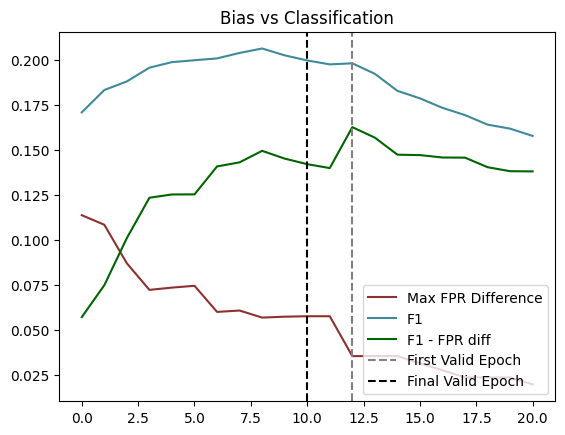

In [157]:
#fig, axes = plt.subplots(nrows=1, ncols=2)
epochs = range(len(d["parity_hist"]["max_diff"]))

f1 = 2 * np.multiply(d["history_val"]["val_precision"], d["history_val"]["val_recall"]) / np.add(d["history_val"]["val_precision"], d["history_val"]["val_recall"])

first_valid_epoch = [x <= .05 for x in d["parity_hist"]["max_diff"]].index(True)
last_valid_epoch = len(d["parity_hist"]["is_valid"]) - 1 - d["parity_hist"]["is_valid"][::-1].index(True)

plt.plot(epochs, d["parity_hist"]["max_diff"], label="Max FPR Difference", color = red)
plt.plot(epochs, f1, label="F1", color = blue)
plt.plot(
        epochs,
        np.subtract(f1,d["parity_hist"]["max_diff"]),
        label="F1 - FPR diff", color = "darkgreen"
    )
plt.axvline(
    first_valid_epoch,
    color = "grey",
    linestyle = "--",
    label = "First Valid Epoch"
)
plt.axvline(
    last_valid_epoch,
    color = "black",
    linestyle = "--",
    label = "Final Valid Epoch"
)
plt.title("Bias vs Classification")
plt.legend(loc="lower right")
plt.show()

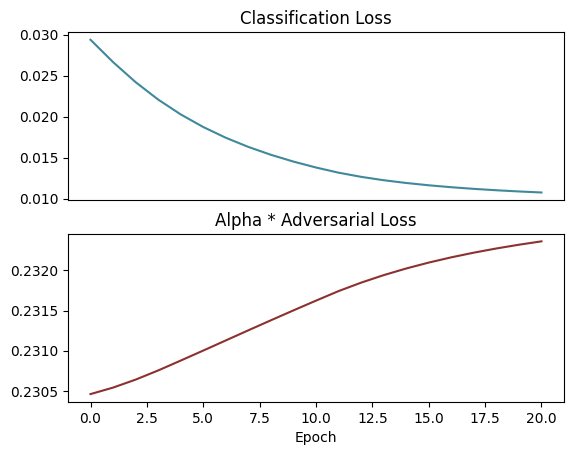

In [158]:
fig, axes = plt.subplots(nrows=2,ncols=1)

axes[0].plot(epochs, d["clf_loss"], label = "Predictor Loss", color = blue)
axes[0].set_title("Classification Loss")
axes[0].set_xticks([])
axes[1].set_title("Alpha * Adversarial Loss")
axes[1].plot(epochs, np.multiply(d["adv_loss"], .15), label = "Adversary Loss", color = red)
plt.xlabel("Epoch")
fig.subplots_adjust(wspace=0)
plt.show()

In [159]:
model_clf.set_weights(d["weights"][12])

In [160]:
get_performance_metrics_by_hist(d["history_val"], epoch = 12)

tn: 183595.0	fp:1390.0
fn: 1746.0	tp: 387.0
recall: 0.18143460154533386	precision: 0.21778278052806854	auc: 0.8710420727729797


In [161]:
y_pred = model_clf(X_clf)
equalized_odds_ratio(
            y_clf,
            y_pred > 0.5,
            sensitive_features = X_train_transformed["customer_age"]
        )

NameError: name 'X_clf' is not defined

In [ ]:
model_clf(X_valid_transformed.values).numpy()

array([[0.00541315],
       [0.003766  ],
       [0.1396666 ],
       ...,
       [0.00584203],
       [0.0070083 ],
       [0.04517027]], dtype=float32)

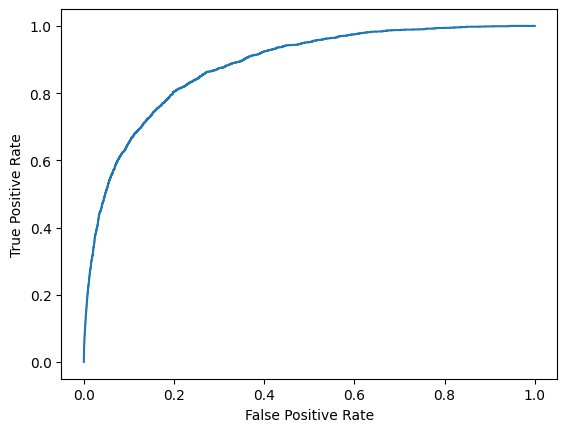

0.8813920113270599


In [ ]:
#define metrics
y_pred_proba = model_clf(X_valid_transformed.values).numpy()
fpr, tpr, _ = roc_curve(y_valid_transformed,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Print area
print(roc_auc_score(y_valid_transformed, y_pred_proba))

In [ ]:
d2 = get_disparity_df_tf(model_clf, X_valid_transformed.values)
get_parity_df(d2, ["age"])

ValueError: operands could not be broadcast together with shapes (187078,) (187078,46) 

In [ ]:
get_disparity_dict(d2)

age category is fair!
            Max fpr: 0.06358459261916506
            Max value: 40
            Max n: 44602
            Min fpr: 0.02172096908939014
            Min value: 70
            Min_n: 1197
            Difference: 0.04186362352977492





{'age': [[50,
   26242,
   0.0069735538449813275,
   0.052511241521225514,
           true_label  pred_prob  pred_label  true_pos  true_neg  false_pos  \
   163001           0   0.002955       False     False      True      False   
   402173           0   0.025147       False     False      True      False   
   860502           0   0.004424       False     False      True      False   
   621248           1   0.051649        True      True     False      False   
   887138           0   0.012176       False     False      True      False   
   ...            ...        ...         ...       ...       ...        ...   
   707249           0   0.011181       False     False      True      False   
   834242           0   0.001845       False     False      True      False   
   3514             0   0.000720       False     False      True      False   
   867933           0   0.008388       False     False      True      False   
   996167           0   0.005827       False     False  

In [ ]:
y_pred = model_clf(X_clf)

In [ ]:
y_pred

<tf.Tensor: shape=(562294, 1), dtype=float32, numpy=
array([[1.3493628e-06],
       [2.0512082e-02],
       [2.1997203e-04],
       ...,
       [8.4958476e-04],
       [2.0700548e-04],
       [2.7275550e-07]], dtype=float32)>

In [ ]:
roc_auc_score(y_clf,y_pred)

0.8296333016798976

In [ ]:
y_pred > .2

<tf.Tensor: shape=(562294, 1), dtype=bool, numpy=
array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])>

In [ ]:
confusion_matrix(y_clf,y_pred > .04)

array([[530439,  25603],
       [  3972,   2280]], dtype=int64)

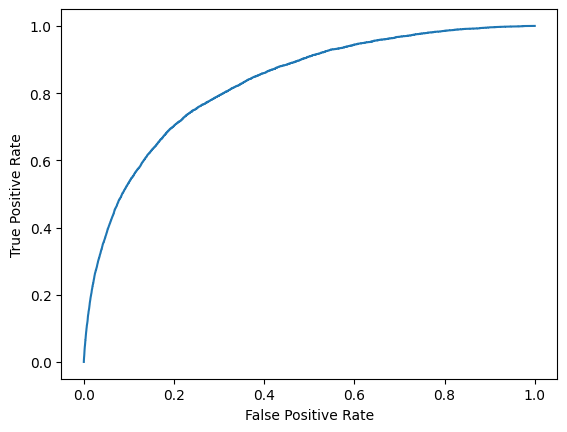

In [ ]:
fpr, tpr, _ = roc_curve(y_clf,  y_pred)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Perform Adversarial Debiasing

In [ ]:
#torch.save(clf_model, "clf_model.pt")

### Stop

In [ ]:
# H0: p1 - p2 = 0,  Proportions are the same
# H1: p1 - p2 != 0, Proportions are different

def compare_proportions(s1: pd.DataFrame, s2: pd.DataFrame, a: float = .05):
    n1 = len(s1.index) # Length of sample 1
    n2 = len(s2.index) # Length of sample 2
    p1 = sum(s1["false_pos"]) / n1 # FP proportion for sample 1
    p2 = sum(s2["false_pos"]) / n2 # FP proportion for sample 2
    p = (   # Proportion for combined samples
            (sum(s1["false_pos"]) + sum(s2["false_pos"]))
            /(n1 + n2)
        )
    Z = (
        ((p1 - p2) - 0)
        / np.sqrt(p * (1-p) * ((1/n1)+(1/n2)))
    )
    pval = 2*dist.norm.cdf(-np.abs(Z))
    return pval

compare_proportions(disparity_dict['age'][0][-1], disparity_dict['age'][3][-1]) 


NameError: name 'disparity_dict' is not defined

In [ ]:
pvals = np.zeros((len(disparity_dict["age"]),len(disparity_dict["age"])))
for r, row in enumerate(pvals):
    for c, col in enumerate(row):
        pvals[r][c] = (compare_proportions(disparity_dict['age'][r][-1], disparity_dict['age'][c][-1]))
pvals

array([[1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        2.90301776e-062, 0.00000000e+000, 1.90961480e-003,
        0.00000000e+000, 2.31180807e-120, 2.66104671e-016],
       [0.00000000e+000, 1.00000000e+000, 1.72412363e-083,
        0.00000000e+000, 3.56963247e-011, 2.90802701e-109,
        5.67367723e-002, 1.18559354e-002, 2.93824271e-001],
       [0.00000000e+000, 1.72412363e-083, 1.00000000e+000,
        4.82231058e-186, 7.88593120e-075, 1.12237947e-048,
        3.27939147e-034, 7.46372778e-015, 5.67902550e-003],
       [2.90301776e-062, 0.00000000e+000, 4.82231058e-186,
        1.00000000e+000, 0.00000000e+000, 5.70305203e-015,
        4.67048587e-143, 1.99349742e-051, 1.66074184e-007],
       [0.00000000e+000, 3.56963247e-011, 7.88593120e-075,
        0.00000000e+000, 1.00000000e+000, 6.17665514e-086,
        3.76296127e-008, 1.57643919e-005, 1.03926269e-001],
       [1.90961480e-003, 2.90802701e-109, 1.12237947e-048,
        5.70305203e-015, 6.17665514e-086, 1.0000000

In [ ]:
def get_pval_array(disparity_dict):
    pvals = np.zeros((len(disparity_dict["age"]),len(disparity_dict["age"])))
    for r, row in enumerate(pvals):
        for c, col in enumerate(row):
            pvals[r][c] = (compare_proportions(disparity_dict['age'][r][-1], disparity_dict['age'][c][-1]))
    
    return pvals

def plot_pval_heatmap(disparity_dict):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,8))

    for i, cat in enumerate(disparity_dict):
        ax = axes[i]
        pvals = np.zeros((len(disparity_dict[cat]),len(disparity_dict[cat])))
        for r, row in enumerate(pvals):
            for c, col in enumerate(row):
                pvals[r][c] = (compare_proportions(disparity_dict[cat][r][-1], disparity_dict[cat][c][-1]))
        im = ax.imshow(pvals, cmap="Reds_r")
        ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

        # Show all ticks and label them with the respective list entries
        if cat != "income":
            ax.set_xticks(np.arange(len(pvals)), labels=[x[0] for x in disparity_dict[cat]])
            ax.set_yticks(np.arange(len(pvals)), labels=[x[0] for x in disparity_dict[cat]])
        else:
            ax.set_xticks(np.arange(len(pvals)), labels=['%.1f' % x[0] for x in disparity_dict[cat]])
            ax.set_yticks(np.arange(len(pvals)), labels=['%.1f' % x[0] for x in disparity_dict[cat]])
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), ha="center")

        # Loop over data dimensions and create text annotations.
        for i in range(len(pvals)):
            for j in range(len(pvals[0])):
                text = ax.text(j, i, '%.3f' % pvals[i, j],
                            ha="center", va="center", color="w")

        ax.set_title(f"Pvals for Proportion difference by {cat}")
        #fig.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([.15, .05, .6, 0.025])
    fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
    fig.suptitle("FPR Proportion Significance: P-Values by Category", size=20)
    plt.show()

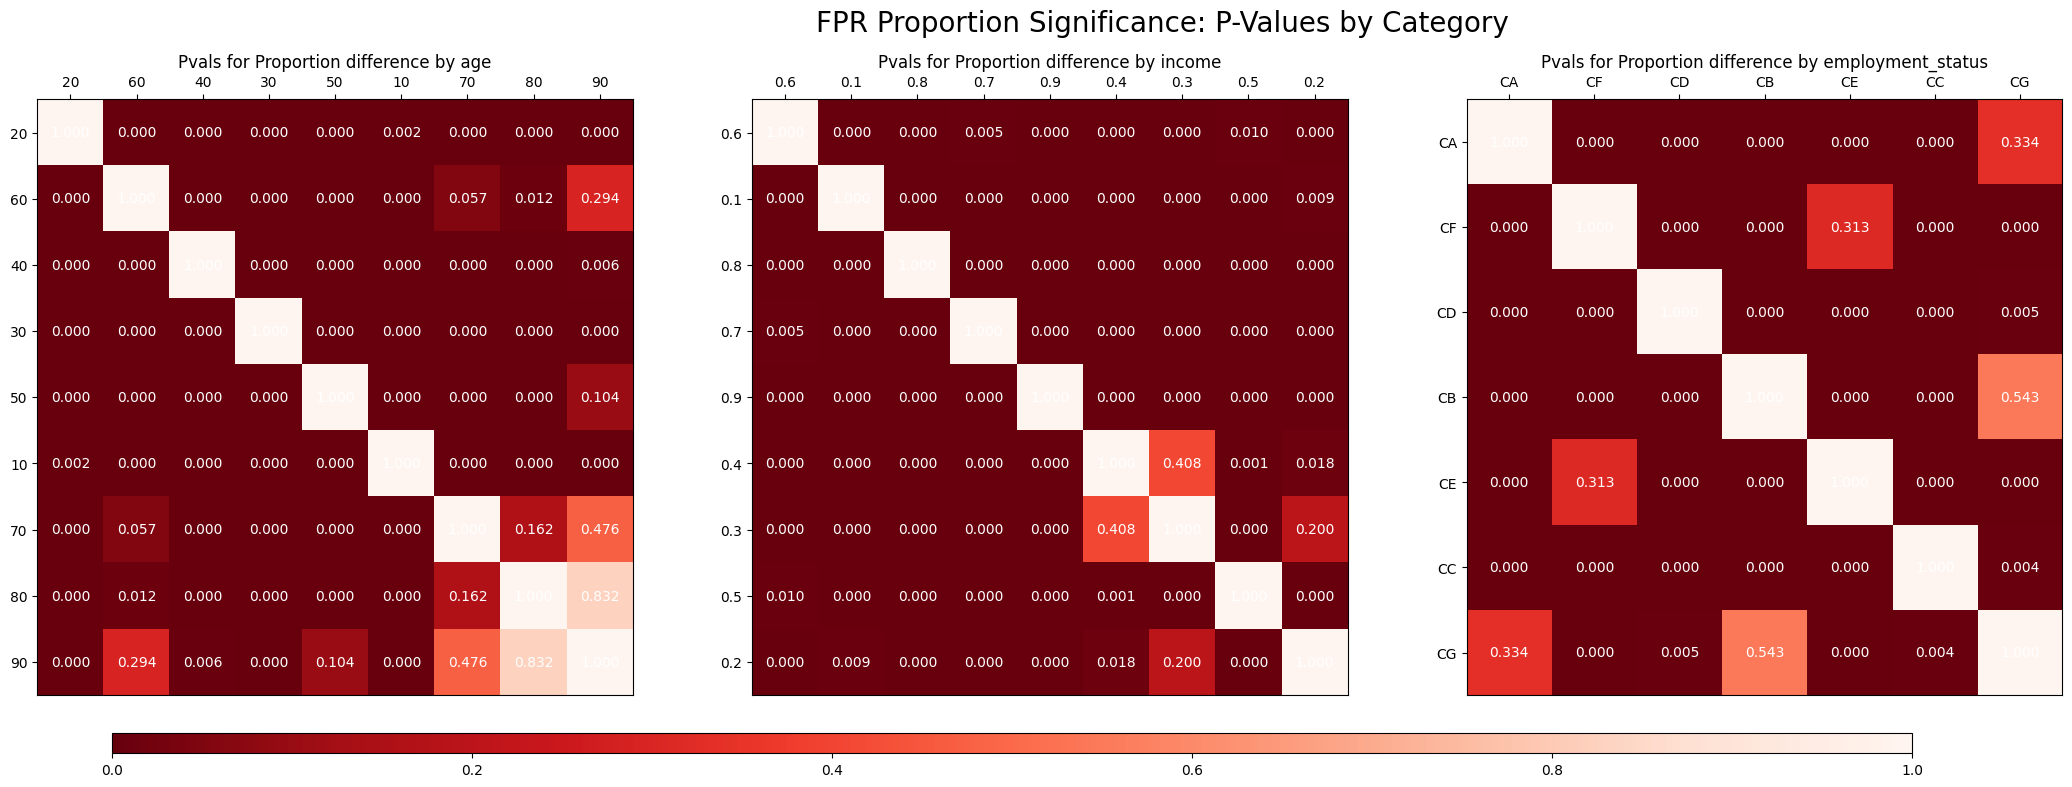

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,8))

for i, cat in enumerate(disparity_dict):
    ax = axes[i]
    pvals = np.zeros((len(disparity_dict[cat]),len(disparity_dict[cat])))
    for r, row in enumerate(pvals):
        for c, col in enumerate(row):
            pvals[r][c] = (compare_proportions(disparity_dict[cat][r][-1], disparity_dict[cat][c][-1]))
    im = ax.imshow(pvals, cmap="Reds_r")
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    # Show all ticks and label them with the respective list entries
    if cat != "income":
        ax.set_xticks(np.arange(len(pvals)), labels=[x[0] for x in disparity_dict[cat]])
        ax.set_yticks(np.arange(len(pvals)), labels=[x[0] for x in disparity_dict[cat]])
    else:
        ax.set_xticks(np.arange(len(pvals)), labels=['%.1f' % x[0] for x in disparity_dict[cat]])
        ax.set_yticks(np.arange(len(pvals)), labels=['%.1f' % x[0] for x in disparity_dict[cat]])
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="center")

    # Loop over data dimensions and create text annotations.
    for i in range(len(pvals)):
        for j in range(len(pvals[0])):
            text = ax.text(j, i, '%.3f' % pvals[i, j],
                        ha="center", va="center", color="w")

    ax.set_title(f"Pvals for Proportion difference by {cat}")
    #fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([.15, .05, .6, 0.025])
fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
fig.suptitle("FPR Proportion Significance: P-Values by Category", size=20)
plt.show()

## Try to fix bias!!

<BarContainer object of 45 artists>

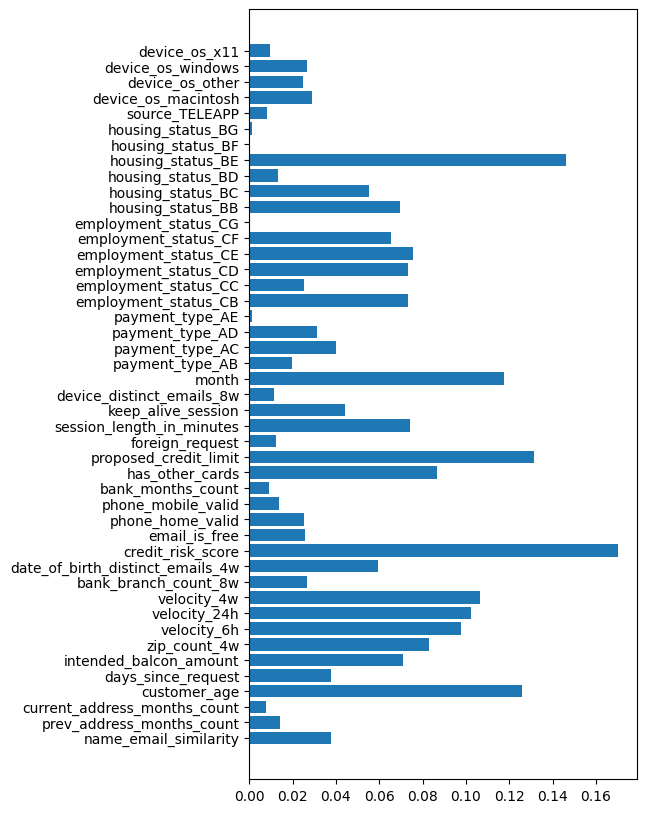

In [ ]:
# Get correlations
corr = X_train_transformed.corr()["income"]
corr = corr.drop("income")
plt.rcParams["figure.figsize"] = [5.0, 10.0]
plt.barh(corr.index,np.abs(corr.values))

<BarContainer object of 45 artists>

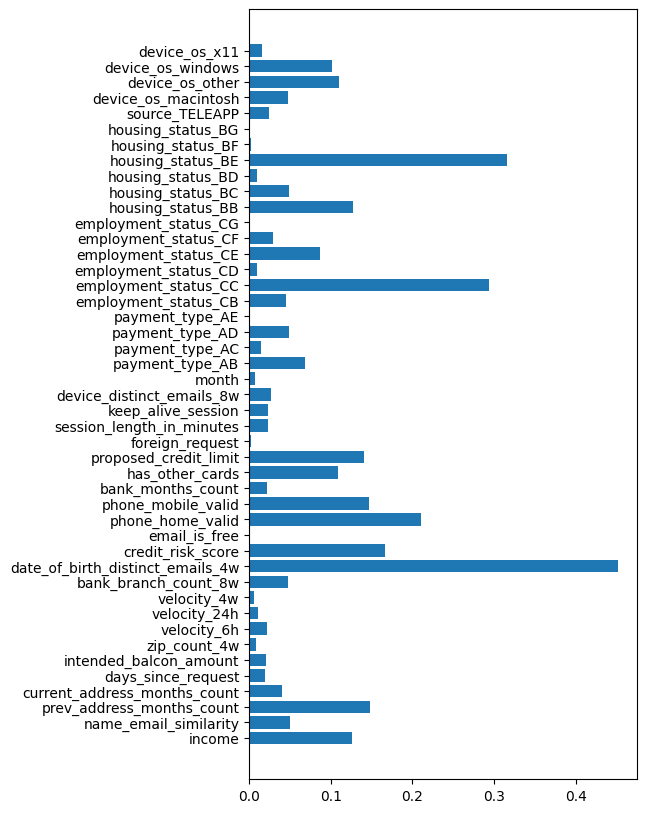

In [ ]:
# Get correlations
corr = X_train_transformed.corr()["customer_age"]
corr = corr.drop("customer_age")
plt.rcParams["figure.figsize"] = [5.0, 10.0]
plt.barh(corr.index,np.abs(corr.values))

In [ ]:
# Get correlations
corr = X_train_transformed.corr()[['employment_status_CB', 'employment_status_CC', 'employment_status_CD',
       'employment_status_CE', 'employment_status_CF', 'employment_status_CG',]]
#corr = corr.drop("employment_status")
#plt.rcParams["figure.figsize"] = [5.0, 10.0]
#plt.barh(corr.index,np.abs(corr.values))
corr

,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG
income,0.073308,-0.025070,-0.073121,-0.075376,-0.065468,0.000372
name_email_similarity,-0.042926,-0.031374,-0.008219,0.030863,-0.019869,-0.002627
prev_address_months_count,-0.074092,-0.048180,-0.007229,-0.022552,-0.005334,0.000475
current_address_months_count,0.015124,0.018507,-0.004926,0.002560,-0.003365,0.000410
customer_age,0.045011,0.293919,0.009764,-0.086432,0.029681,0.000456
days_since_request,-0.003533,0.011674,0.026950,0.003163,-0.011131,0.004317
intended_balcon_amount,0.032621,-0.031037,-0.032438,0.032427,-0.062038,0.001658
zip_count_4w,0.051041,0.000883,0.011992,0.002003,0.010646,-0.002087
velocity_6h,0.055442,0.011238,0.017359,0.011105,0.007981,0.000721
velocity_24h,0.071895,0.017198,0.016960,0.008154,-0.003549,0.000159


In [ ]:
X_train_transformed.columns

Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'email_is_free', 'phone_home_valid', 'phone_mobile_valid',
       'bank_months_count', 'has_other_cards', 'proposed_credit_limit',
       'foreign_request', 'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w', 'month', 'payment_type_AB',
       'payment_type_AC', 'payment_type_AD', 'payment_type_AE',
       'employment_status_CB', 'employment_status_CC', 'employment_status_CD',
       'employment_status_CE', 'employment_status_CF', 'employment_status_CG',
       'housing_status_BB', 'housing_status_BC', 'housing_status_BD',
       'housing_status_BE', 'housing_status_BF', 'housing_status_BG',
       'source_TELEAP

In [ ]:
groups = ["income", "customer_age", "employment_status"]
cols = [x for x in X_train_transformed.columns if not any([y in x for y in groups])]
X_train_fair = X_train_transformed[cols]
X_valid_fair = X_valid_transformed[cols]

In [ ]:
ann2 = MLPClassifier(
    hidden_layer_sizes = (10),
    activation = 'tanh',
    solver = 'adam',
    learning_rate_init = .001,
    max_iter = 1000
    ).fit(X_train_fair, y_train_transformed)

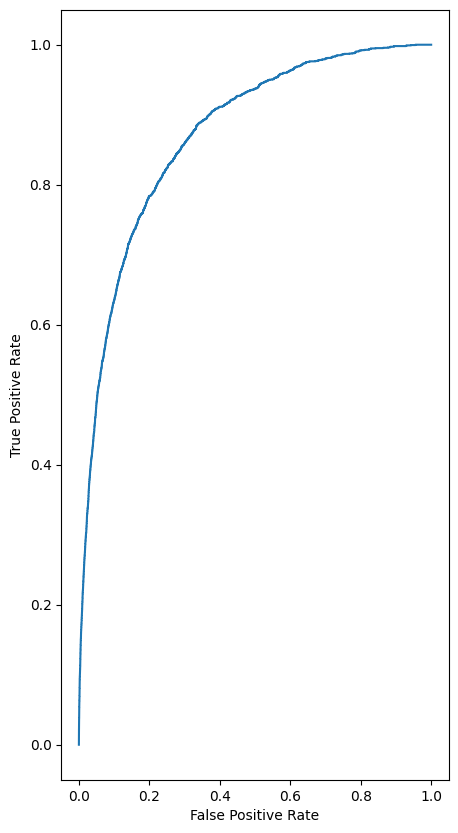

0.8703789298610232


In [ ]:
#define metrics
y_pred_proba = ann2.predict_proba(X_valid_fair)[::,1]
fpr, tpr, _ = roc_curve(y_valid_transformed,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Print area
print(roc_auc_score(y_valid_transformed, ann2.predict_proba(X_valid_fair)[:, 1]))

In [ ]:
ddf = get_disparity_df(ann2, X_valid_fair)
ddf

TPR:  48.86% 
FPR:  5.0% 
Prob Threshold:  0.05


,true_label,pred_prob,pred_label,true_pos,true_neg,false_pos,false_neg,age,income,employment_status
751477,0,0.000972,False,False,True,False,False,20,0.6,CA
974413,0,0.004391,False,False,True,False,False,60,0.1,CA
182186,0,0.001326,False,False,True,False,False,40,0.8,CA
595545,0,0.015924,False,False,True,False,False,30,0.8,CA
939928,0,0.000208,False,False,True,False,False,40,0.7,CA
...,...,...,...,...,...,...,...,...,...,...
603793,0,0.004414,False,False,True,False,False,30,0.8,CA
823365,0,0.005319,False,False,True,False,False,30,0.6,CA
899612,0,0.000663,False,False,True,False,False,20,0.6,CE
668928,0,0.006848,False,False,True,False,False,30,0.7,CB


In [ ]:
#Test for independence
ct = pd.crosstab(ddf["employment_status"], ddf["pred_label"])
stats.chi2_contingency(ct)

Chi2ContingencyResult(statistic=1037.745277411166, pvalue=6.126913265871676e-221, dof=6, expected_freq=array([[1.29209210e+05, 7.49579001e+03],
       [2.43787217e+04, 1.41427828e+03],
       [6.70596792e+03, 3.89032077e+02],
       [4.62187218e+03, 2.68127816e+02],
       [4.02074525e+03, 2.33254751e+02],
       [7.79952746e+03, 4.52472544e+02],
       [8.69554685e+01, 5.04453151e+00]]))

In [ ]:
ddct = get_disparity_dict(ddf)

age category is NOT fair!
            Max fpr: 0.12137823022709475
            Max value: 70
            Max n: 1277
            Min fpr: 0.01571759855707292
            Min value: 10
            Min n: 3881
            Difference: 0.10566063167002183





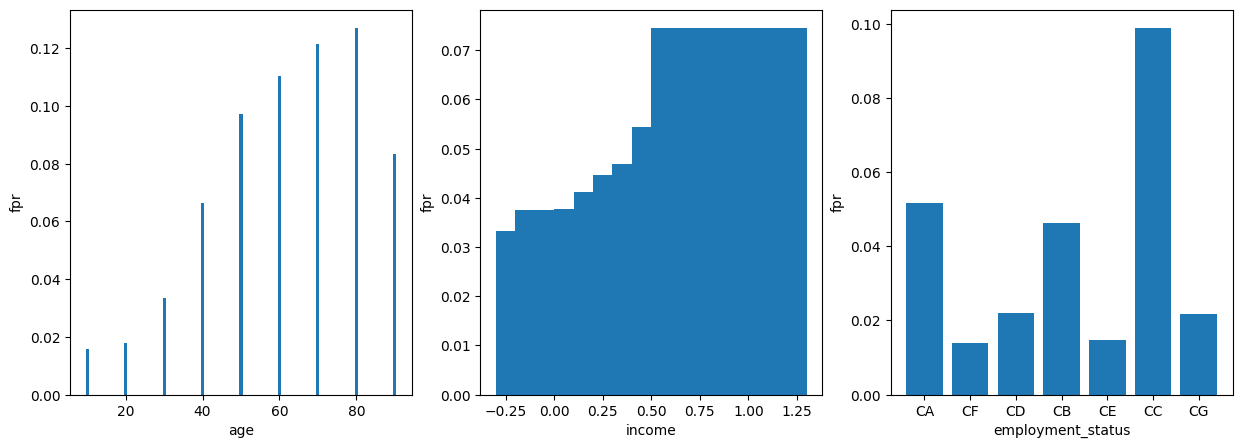

In [ ]:
plot_fpr_by_cat(ddct)

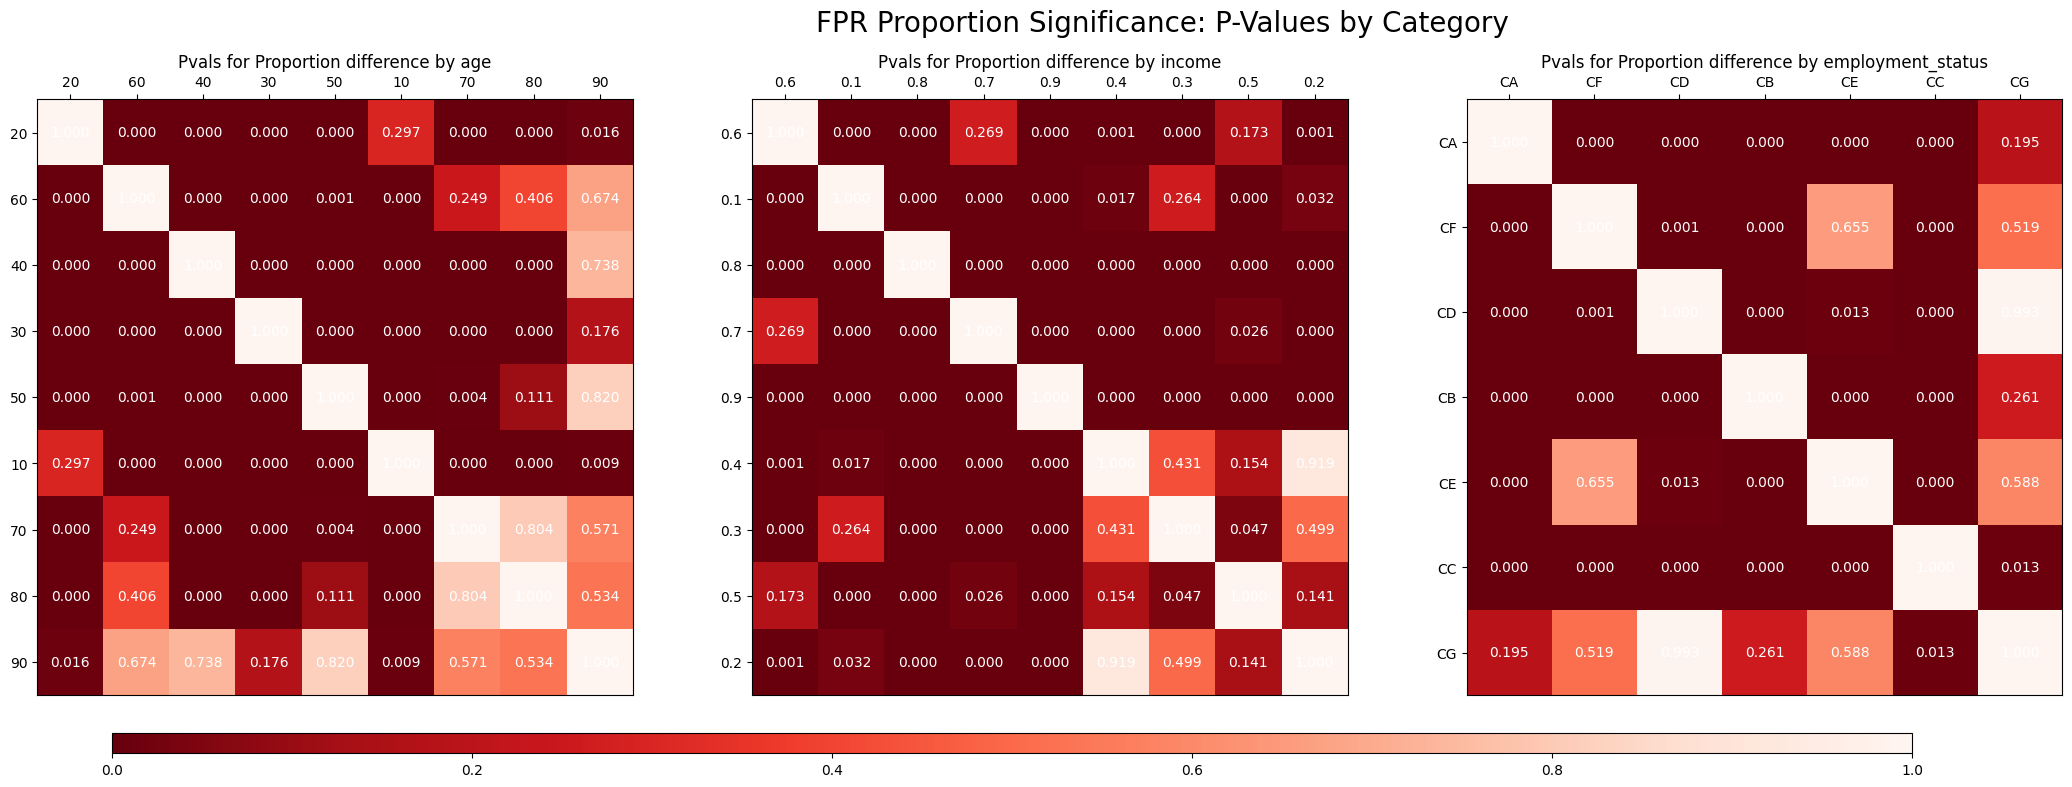

In [ ]:
plot_pval_heatmap(ddct)